In [4]:
!pip install torchinfo

In [5]:
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn
from torchinfo import summary
from tqdm.notebook import tqdm

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

import yfinance as yf
from itertools import product
import numpy as np

In [6]:
start = "2004-08-19"
interval = "1d"

# load s&p 500 data
gspc = yf.Ticker("^GSPC")
gspc_data = gspc.history(period="max", interval=interval, start=start)
gspc_data = gspc_data[["Open", "High", "Low", "Close", "Volume"]]

spy = yf.Ticker("SPY")
spy_data = spy.history(period="max", interval=interval, start=start)
spy_data = spy_data[["Open", "High", "Low", "Close", "Volume"]]
spy_data = spy_data.rename(columns={"Open": "spy_open", "High": "spy_high", "Low": "spy_low", "Close": "spy_close", "Volume": "spy_volume"})

goog = yf.Ticker("GOOG")
goog_data = goog.history(period="max", interval=interval, start=start)
goog_data = goog_data[["Open", "High", "Low", "Close", "Volume"]]
goog_data = goog_data.rename(columns={"Open": "goog_open", "High": "goog_high", "Low": "goog_low", "Close": "goog_close", "Volume": "goog_volume"})

aapl = yf.Ticker("AAPL")
aapl_data = aapl.history(period="max", interval=interval, start=start)
aapl_data = aapl_data[["Open", "High", "Low", "Close", "Volume"]]
aapl_data = aapl_data.rename(columns={"Open": "aapl_open", "High": "aapl_high", "Low": "aapl_low", "Close": "aapl_close", "Volume": "aapl_volume"})

amzn = yf.Ticker("AMZN")
amzn_data = amzn.history(period="max", interval=interval, start=start)
amzn_data = amzn_data[["Open", "High", "Low", "Close", "Volume"]]
amzn_data = amzn_data.rename(columns={"Open": "amzn_open", "High": "amzn_high", "Low": "amzn_low", "Close": "amzn_close", "Volume": "amzn_volume"})
amzn_data = amzn_data.dropna()

msft = yf.Ticker("MSFT")
msft_data = msft.history(period="max", interval=interval, start=start)
msft_data = msft_data[["Open", "High", "Low", "Close", "Volume"]]
msft_data = msft_data.rename(columns={"Open": "msft_open", "High": "msft_high", "Low": "msft_low", "Close": "msft_close", "Volume": "msft_volume"})
msft_data = msft_data.dropna()

# merge all stock data
df = pd.concat([gspc_data, spy_data, goog_data, aapl_data, amzn_data, msft_data], axis=1)
df = df.dropna()
df

,Open,High,Low,Close,Volume,spy_open,spy_high,spy_low,spy_close,spy_volume,...,amzn_open,amzn_high,amzn_low,amzn_close,amzn_volume,msft_open,msft_high,msft_low,msft_close,msft_volume
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-19 00:00:00-04:00,1095.170044,1095.170044,1086.280029,1091.229980,1249400000,75.200500,75.344313,74.769063,75.132019,39881600,...,2.013000,2.024000,1.817500,1.931500,253922000,17.074388,17.136818,16.862129,16.930801,46293000
2004-08-20 00:00:00-04:00,1091.229980,1100.260010,1089.569946,1098.349976,1199900000,75.063519,75.762036,74.995037,75.659317,44870900,...,1.923000,1.995500,1.905500,1.975500,135816000,16.937038,17.086869,16.880853,16.980740,46494800
2004-08-23 00:00:00-04:00,1098.349976,1101.400024,1094.729980,1095.680054,1021900000,75.707275,75.857932,75.364863,75.467583,33745100,...,1.994500,2.000000,1.955500,1.972500,110652000,17.074666,17.112234,16.980746,17.055882,39572200
2004-08-24 00:00:00-04:00,1095.680054,1100.939941,1092.819946,1096.189941,1092500000,75.768927,75.830564,75.227916,75.570328,30453100,...,1.986000,1.996500,1.916000,1.952500,152808000,17.156063,17.193630,16.961962,17.055882,40835300
2004-08-25 00:00:00-04:00,1096.189941,1106.290039,1093.239990,1104.959961,1192200000,75.556626,76.200357,75.262152,76.083939,38551400,...,1.953000,2.024500,1.908000,2.015000,145096000,17.037090,17.325112,17.018307,17.249975,53512700
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-06 00:00:00-04:00,5142.419922,5181.000000,5142.419922,5180.740234,3683250000,513.750000,516.609985,513.299988,516.570007,47264700,...,186.279999,188.750000,184.800003,188.699997,34725300,408.760010,413.929993,406.369995,413.540009,16996600
2024-05-07 00:00:00-04:00,5187.200195,5200.229980,5178.959961,5187.700195,3987890000,517.559998,518.570007,516.450012,517.140015,52561300,...,188.919998,189.940002,187.309998,188.759995,34048900,414.660004,414.670013,409.089996,409.339996,20018200
2024-05-08 00:00:00-04:00,5168.979980,5191.950195,5165.859863,5187.669922,3842100000,515.260010,517.739990,515.140015,517.190002,42047200,...,187.440002,188.429993,186.389999,188.000000,26136400,408.170013,412.230011,406.709991,410.540009,11792300


In [7]:
# df = pd.read_csv('GOOG.csv', index_col="Date")
# df = df.drop(['Adj Close'], axis = 1)

target_col = "Close"
features = list(df.columns.difference([target_col]))

forecast_lead = 1
target = f"{target_col}_lead{forecast_lead}"

df[target] = df[target_col].shift(-forecast_lead)
df = df.iloc[:-forecast_lead]
df

,Open,High,Low,Close,Volume,spy_open,spy_high,spy_low,spy_close,spy_volume,...,amzn_high,amzn_low,amzn_close,amzn_volume,msft_open,msft_high,msft_low,msft_close,msft_volume,Close_lead1
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-19 00:00:00-04:00,1095.170044,1095.170044,1086.280029,1091.229980,1249400000,75.200500,75.344313,74.769063,75.132019,39881600,...,2.024000,1.817500,1.931500,253922000,17.074388,17.136818,16.862129,16.930801,46293000,1098.349976
2004-08-20 00:00:00-04:00,1091.229980,1100.260010,1089.569946,1098.349976,1199900000,75.063519,75.762036,74.995037,75.659317,44870900,...,1.995500,1.905500,1.975500,135816000,16.937038,17.086869,16.880853,16.980740,46494800,1095.680054
2004-08-23 00:00:00-04:00,1098.349976,1101.400024,1094.729980,1095.680054,1021900000,75.707275,75.857932,75.364863,75.467583,33745100,...,2.000000,1.955500,1.972500,110652000,17.074666,17.112234,16.980746,17.055882,39572200,1096.189941
2004-08-24 00:00:00-04:00,1095.680054,1100.939941,1092.819946,1096.189941,1092500000,75.768927,75.830564,75.227916,75.570328,30453100,...,1.996500,1.916000,1.952500,152808000,17.156063,17.193630,16.961962,17.055882,40835300,1104.959961
2004-08-25 00:00:00-04:00,1096.189941,1106.290039,1093.239990,1104.959961,1192200000,75.556626,76.200357,75.262152,76.083939,38551400,...,2.024500,1.908000,2.015000,145096000,17.037090,17.325112,17.018307,17.249975,53512700,1105.089966
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-03 00:00:00-04:00,5122.779785,5139.120117,5101.220215,5127.790039,3924990000,511.160004,512.549988,508.559998,511.290009,72756700,...,187.869995,185.419998,186.210007,39172000,402.279999,407.149994,401.859985,406.660004,17446700,5180.740234
2024-05-06 00:00:00-04:00,5142.419922,5181.000000,5142.419922,5180.740234,3683250000,513.750000,516.609985,513.299988,516.570007,47264700,...,188.750000,184.800003,188.699997,34725300,408.760010,413.929993,406.369995,413.540009,16996600,5187.700195
2024-05-07 00:00:00-04:00,5187.200195,5200.229980,5178.959961,5187.700195,3987890000,517.559998,518.570007,516.450012,517.140015,52561300,...,189.940002,187.309998,188.759995,34048900,414.660004,414.670013,409.089996,409.339996,20018200,5187.669922


<Axes: xlabel='Date'>

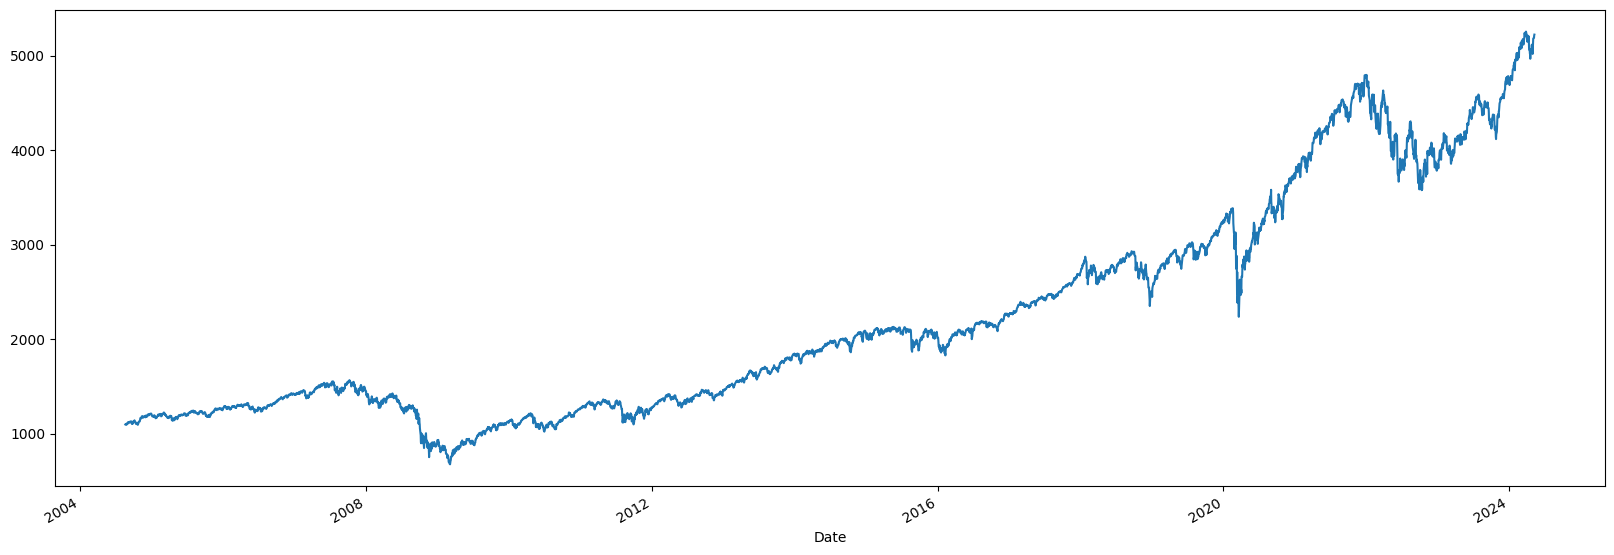

In [8]:
df[target].plot(figsize=(20, 7))

In [9]:
# add volatility as features
df["volatility"] = df["High"] - df["Low"]

# add ema as features
df["ema_5"] = df["Close"].ewm(span=5, adjust=False).mean()
df["ema_10"] = df["Close"].ewm(span=10, adjust=False).mean()
df["ema_20"] = df["Close"].ewm(span=20, adjust=False).mean()
df["ema_50"] = df["Close"].ewm(span=50, adjust=False).mean()
df["ema_100"] = df["Close"].ewm(span=100, adjust=False).mean()

<ipython-input-9-1103376d4c66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["volatility"] = df["High"] - df["Low"]
<ipython-input-9-1103376d4c66>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["ema_5"] = df["Close"].ewm(span=5, adjust=False).mean()
<ipython-input-9-1103376d4c66>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [10]:
val_start = "2020-05-01"
test_start = "2022-05-01"


df_train = df.loc[:val_start].copy()
df_val = df.loc[val_start:test_start].copy()
df_test = df.loc[test_start:].copy()

In [12]:
df_val

,Open,High,Low,Close,Volume,spy_open,spy_high,spy_low,spy_close,spy_volume,...,msft_low,msft_close,msft_volume,Close_lead1,volatility,ema_5,ema_10,ema_20,ema_50,ema_100
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-01 00:00:00-04:00,1.819334,1.800038,1.764905,1.757586,0.851865,1.924001,1.982224,1.889556,1.886860,-0.131436,...,3.601951,3.565037,-0.351812,1.775653,1.695388,1.821430,1.790043,1.722834,1.782890,1.971538
2020-05-04 00:00:00-04:00,1.732812,1.760376,1.726774,1.776835,0.833171,1.857615,1.884394,1.854699,1.898189,-0.581847,...,3.596170,3.681254,-0.652723,1.816763,1.629510,1.807724,1.788996,1.729383,1.784147,1.969355
2020-05-05 00:00:00-04:00,1.818998,1.846547,1.832211,1.817955,1.149714,1.943322,1.961819,1.921498,1.936242,-0.595096,...,3.764083,3.733513,-0.436468,1.784739,0.921839,1.812309,1.795633,1.739242,1.786986,1.968051
2020-05-06 00:00:00-04:00,1.841812,1.835183,1.806694,1.785923,0.955792,1.963657,1.950384,1.922517,1.908063,-0.655453,...,3.811705,3.781960,-0.593649,1.837157,1.452460,1.804676,1.795226,1.745098,1.788443,1.966122
2020-05-07 00:00:00-04:00,1.834005,1.852436,1.852961,1.838355,1.179853,1.959445,1.969488,1.971377,1.957881,-0.639007,...,3.837854,3.810810,-0.721513,1.914914,0.363435,1.817085,1.804449,1.755412,1.791923,1.965297
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-25 00:00:00-04:00,4.037182,4.082274,3.978281,4.102266,1.227801,4.114869,4.162213,4.071988,4.186327,-0.187676,...,6.402501,6.594680,-0.475272,3.907043,4.760578,4.191818,4.264047,4.326662,4.401204,4.522541
2022-04-26 00:00:00-04:00,4.073660,4.048949,3.936909,3.908792,0.797192,4.147169,4.122735,4.030400,4.000783,-0.346784,...,6.380916,6.303641,-0.112762,3.921055,5.056696,4.099450,4.201735,4.289203,4.384364,4.513178
2022-04-27 00:00:00-04:00,3.927078,3.989209,3.917427,3.922808,0.859591,4.018717,4.076255,4.014486,4.018275,-0.163458,...,6.637700,6.663977,0.454416,4.086677,3.528335,4.042548,4.153307,4.256653,4.368740,4.504286


In [13]:
df_test

,Open,High,Low,Close,Volume,spy_open,spy_high,spy_low,spy_close,spy_volume,...,msft_low,msft_close,msft_volume,Close_lead1,volatility,ema_5,ema_10,ema_20,ema_50,ema_100
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-02 00:00:00-04:00,3.837628,3.876049,3.756319,3.877079,1.168110,3.941407,3.971973,3.864498,3.976562,0.205381,...,6.555280,6.698622,-0.492924,3.907491,5.310513,3.953254,4.054206,4.177844,4.326529,4.479300
2022-05-03 00:00:00-04:00,3.884297,3.924393,3.892039,3.909240,0.712710,3.985371,4.016814,3.989713,4.004970,-0.387122,...,6.665450,6.624060,-0.799684,4.106944,2.030191,3.940556,4.030129,4.154602,4.312635,4.470803
2022-05-04 00:00:00-04:00,3.918535,4.096064,3.894976,4.108745,1.146637,4.016324,4.176664,3.994968,4.194550,0.062404,...,6.569580,6.851350,-0.544821,3.861727,8.419804,3.998669,4.046790,4.152660,4.307201,4.466529
2022-05-05 00:00:00-04:00,4.061325,4.036643,3.826129,3.863463,1.100192,4.128028,4.107241,3.930859,3.966544,0.353969,...,6.502580,6.501271,-0.221721,3.824088,8.762485,3.955556,4.015718,4.127437,4.292249,4.457355
2022-05-06 00:00:00-04:00,3.833724,3.856705,3.764985,3.825815,1.131435,3.926902,3.955288,3.875158,3.929615,0.138879,...,6.416518,6.428649,-0.404994,3.612782,4.251720,3.914251,3.983434,4.101013,4.276390,4.447596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-03 00:00:00-04:00,5.424992,5.423114,5.423257,5.432951,0.198347,5.665234,5.653325,5.660827,5.666075,-0.664357,...,10.281215,10.289483,-1.085020,5.515495,1.116432,5.363152,5.362257,5.398609,5.430416,5.349065
2024-05-06 00:00:00-04:00,5.456414,5.489956,5.489375,5.517672,0.009107,5.705190,5.715724,5.734246,5.747517,-0.923502,...,10.409932,10.483634,-1.100073,5.526628,1.157537,5.417246,5.393493,5.412991,5.437044,5.356039
2024-05-07 00:00:00-04:00,5.528057,5.520648,5.548015,5.528808,0.247586,5.763968,5.745848,5.783037,5.756309,-0.869658,...,10.487561,10.365111,-0.999020,5.526580,0.111433,5.457026,5.421079,5.427068,5.443854,5.363101


In [11]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_val[c] = (df_val[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev
df_train.head()

,Open,High,Low,Close,Volume,spy_open,spy_high,spy_low,spy_close,spy_volume,...,msft_low,msft_close,msft_volume,Close_lead1,volatility,ema_5,ema_10,ema_20,ema_50,ema_100
Date,,,,,,,,,,,,,,,,,,,,,
2004-08-19 00:00:00-04:00,-1.018745,-1.031223,-1.019979,-1.025609,-1.896172,-1.060413,-1.066181,-1.058256,-1.061513,-0.998557,...,-0.706717,-0.708534,-0.120300,-1.014656,-0.636731,-1.025344,-1.024854,-1.023720,-1.020204,-1.015375
2004-08-20 00:00:00-04:00,-1.025049,-1.023099,-1.014699,-1.014217,-1.934921,-1.062526,-1.059761,-1.054756,-1.053380,-0.947837,...,-0.706183,-0.707125,-0.113551,-1.018927,-0.527948,-1.021542,-1.022778,-1.022630,-1.019752,-1.015143
2004-08-23 00:00:00-04:00,-1.013657,-1.021279,-1.006418,-1.018489,-2.074264,-1.052595,-1.058287,-1.049028,-1.056337,-1.060939,...,-0.703332,-0.705005,-0.345067,-1.018111,-0.770892,-1.020434,-1.021858,-1.022052,-1.019487,-1.015003
2004-08-24 00:00:00-04:00,-1.017929,-1.022014,-1.009483,-1.017673,-2.018997,-1.051644,-1.058708,-1.051149,-1.054753,-1.094404,...,-0.703868,-0.705005,-0.302824,-1.004083,-0.683266,-1.019422,-1.020956,-1.021452,-1.019201,-1.014849
2004-08-25 00:00:00-04:00,-1.017113,-1.013475,-1.008809,-1.003641,-1.940949,-1.054919,-1.053024,-1.050619,-1.046830,-1.012079,...,-0.702260,-0.699527,0.121152,-1.003875,-0.385327,-1.014065,-1.017661,-1.019566,-1.018368,-1.014413


In [9]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[self.target].values).float()
        self.X = torch.tensor(dataframe[self.features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [10]:
df.corr().style.background_gradient(cmap='coolwarm')

,Open,High,Low,Close,Volume,spy_open,spy_high,spy_low,spy_close,spy_volume,goog_open,goog_high,goog_low,goog_close,goog_volume,aapl_open,aapl_high,aapl_low,aapl_close,aapl_volume,amzn_open,amzn_high,amzn_low,amzn_close,amzn_volume,msft_open,msft_high,msft_low,msft_close,msft_volume,Close_lead1,volatility,ema_5,ema_10,ema_20,ema_50,ema_100
Open,1.000000,0.999926,0.999889,0.999806,0.137675,0.998919,0.998780,0.998910,0.998762,-0.408984,0.983792,0.983745,0.983833,0.983713,-0.493290,0.958369,0.958220,0.958516,0.958279,-0.611265,0.955849,0.955891,0.955877,0.955825,-0.328671,0.962146,0.962001,0.962172,0.962013,-0.506718,0.999557,0.515779,0.999876,0.999641,0.999107,0.997664,0.995479
High,0.999926,1.000000,0.999851,0.999895,0.141092,0.998976,0.998946,0.998978,0.998936,-0.405913,0.984040,0.984075,0.984098,0.984067,-0.492920,0.958989,0.958912,0.959153,0.958995,-0.610341,0.956151,0.956268,0.956191,0.956226,-0.327371,0.962624,0.962560,0.962668,0.962592,-0.504909,0.999637,0.521392,0.999891,0.999693,0.999243,0.997962,0.995925
Low,0.999889,0.999851,1.000000,0.999909,0.132345,0.998754,0.998616,0.998908,0.998748,-0.414943,0.983431,0.983393,0.983590,0.983482,-0.493928,0.957684,0.957542,0.957936,0.957710,-0.613145,0.955371,0.955421,0.955525,0.955479,-0.330988,0.961626,0.961485,0.961765,0.961615,-0.509854,0.999651,0.506575,0.999769,0.999432,0.998784,0.997174,0.994847
Close,0.999806,0.999895,0.999909,1.000000,0.136538,0.998796,0.998764,0.998937,0.998932,-0.410944,0.983676,0.983717,0.983837,0.983856,-0.493549,0.958286,0.958215,0.958540,0.958428,-0.611950,0.955705,0.955828,0.955856,0.955934,-0.329323,0.962091,0.962031,0.962233,0.962203,-0.507629,0.999714,0.513304,0.999797,0.999507,0.998951,0.997513,0.995342
Volume,0.137675,0.141092,0.132345,0.136538,1.000000,0.160433,0.163557,0.156366,0.159728,0.642895,0.197369,0.199124,0.195237,0.197039,-0.219376,0.208053,0.209401,0.206251,0.207670,0.003388,0.216431,0.218070,0.214343,0.216101,0.137998,0.195905,0.197759,0.193739,0.195566,0.176995,0.136601,0.504677,0.139296,0.142173,0.146627,0.155419,0.165085
spy_open,0.998919,0.998976,0.998754,0.998796,0.160433,1.000000,0.999943,0.999926,0.999873,-0.390496,0.986622,0.986642,0.986643,0.986583,-0.501852,0.965054,0.964911,0.965205,0.964979,-0.616446,0.957308,0.957405,0.957303,0.957317,-0.329989,0.967994,0.967887,0.968001,0.967882,-0.504503,0.998577,0.524434,0.998837,0.998644,0.998213,0.997054,0.995356
spy_high,0.998780,0.998946,0.998616,0.998764,0.163557,0.999943,1.000000,0.999880,0.999920,-0.387507,0.986700,0.986800,0.986738,0.986757,-0.501416,0.965484,0.965414,0.965651,0.965498,-0.615539,0.957466,0.957638,0.957474,0.957567,-0.328743,0.968288,0.968261,0.968309,0.968266,-0.502699,0.998547,0.529786,0.998784,0.998633,0.998284,0.997280,0.995720
spy_low,0.998910,0.998978,0.998908,0.998937,0.156366,0.999926,0.999880,1.000000,0.999930,-0.394723,0.986406,0.986438,0.986533,0.986483,-0.502405,0.964563,0.964432,0.964810,0.964594,-0.617804,0.956910,0.957021,0.957020,0.957040,-0.331834,0.967631,0.967531,0.967738,0.967625,-0.506912,0.998719,0.516986,0.998837,0.998565,0.998040,0.996740,0.994923
spy_close,0.998762,0.998936,0.998748,0.998932,0.159728,0.999873,0.999920,0.999930,1.000000,-0.391540,0.986505,0.986609,0.986634,0.986697,-0.502029,0.964980,0.964913,0.965228,0.965114,-0.616826,0.957125,0.957302,0.957233,0.957364,-0.330444,0.967925,0.967899,0.968035,0.968029,-0.505040,0.998693,0.522771,0.998782,0.998551,0.998107,0.996960,0.995282
spy_volume,-0.408984,-0.405913,-0.414943,-0.410944,0.642895,-0.390496,-0.387507,-0.394723,-0.391540,1.000000,-0.338546,-0.337198,-0.340684,-0.339241,0.169832,-0.307794,-0.306927,-0.309192,-0.308285,0.485922,-0.350051,-0.348910,-0.351904,-0.350670,0.353346,-0.314587,-0.313258,-0.316361,-0.315098,0.513853,-0.410845,0.237434,-0.406406,-0.402142,-0.396129,-0.385784,-0.375804


In [11]:
correlation = df.corr()[target]
correlation = correlation[abs(correlation) > 0.9]
correlation = correlation[correlation.index != target]
correlation

Open          0.999557
High          0.999637
Low           0.999651
Close         0.999714
spy_open      0.998577
spy_high      0.998547
spy_low       0.998719
spy_close     0.998693
goog_open     0.983455
goog_high     0.983496
goog_low      0.983616
goog_close    0.983619
aapl_open     0.958093
aapl_high     0.958018
aapl_low      0.958352
aapl_close    0.958218
amzn_open     0.955614
amzn_high     0.955750
amzn_low      0.955782
amzn_close    0.955849
msft_open     0.962005
msft_high     0.961946
msft_low      0.962150
msft_close    0.962100
ema_5         0.999544
ema_10        0.999263
ema_20        0.998718
ema_50        0.997305
ema_100       0.995151
Name: Close_lead1, dtype: float64

In [12]:

# features = correlation.index.tolist()
# features = ['Open','High','Low','Close']
features = ['Close']
print(len(features))
features

1


['Close']

In [13]:
i = 4
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-1.0142],
        [-1.0185],
        [-1.0177],
        [-1.0036]])


In [14]:
# torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([1, 4, 1])
tensor([[[1.1215],
         [1.1225],
         [1.1193],
         [1.1155]]])


In [15]:
torch.manual_seed(101)
np.random.seed(101)
#################################
batch_size = 32
sequence_length = 90
num_consecutive_days = sequence_length
days_pred = 1
num_lstm_hiddensize = 256
lstm_layers = 1
num_features = len(features)
filters = 64
kernel_size = 3
dropout_lstm = 0.2
bidirectional = False
num_epoch = 100
weight_decay = 1e-5
learning_rate = 1e-3
# "dropout_lstm: 0.2
# weight_decay: 1e-05
# learning_rate: 0.001
# num_lstm_hiddensize: 512
# lstm_layers: 1
# filters: 64
# kernel_size: 3
# bidirectional: False
# num_consecutive_days: 90
# days_pred: 1
# num_features: 1
# batch_size: 32"
#################################
train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
val_dataset = SequenceDataset(
    df_val,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
class ResBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels, filter, kernel_size=3, stride=1, padding=1):
        super(ResBlock, self).__init__()
        self.conv1 = torch.nn.Conv1d(in_channels, filter, kernel_size, stride, padding)
        self.conv2 = torch.nn.Conv1d(filter, filter, kernel_size, stride, padding)
        self.linear = torch.nn.Linear(filter, out_channels)
        self.relu = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm1d(filter, eps=1e-5)
        self.bn2 = torch.nn.BatchNorm1d(filter, eps=1e-5)
        self.dropout = nn.Dropout(0.2)
        # intialise weights of the attention mechanism
        self.weight = nn.Parameter(torch.zeros(1)).to(device)


    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.bn1(out)

        out = self.dropout(out)

        out = self.conv2(out)
        out = self.relu(out)
        out = self.bn2(out)

        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = self.weight*out
        out += x.view(x.size(0), -1)
        return out

In [18]:
class ResNLS(torch.nn.Module):
    def __init__(self, in_channels, out_channels, hidden_layer, num_layer, num_feature=4, filter=64, kernel_size=3, dropout=0.2, bidirectional=False):
        super(ResNLS, self).__init__()
        self.resblock = torch.nn.ModuleList([ResBlock(in_channels, in_channels, filter) for i in range(num_feature)])
        self.bidirectional=bidirectional
        self.num_layers = num_layer
        self.hidden_layer = hidden_layer
        self.lstm = torch.nn.LSTM(num_feature, hidden_layer, num_layer, batch_first=True,dropout=dropout,bidirectional=bidirectional)
        self.linear = torch.nn.Linear(hidden_layer, out_channels)


    def forward(self, x):
        batch_size = x.size(0)
        out = torch.split(x, 1, 2)
        out_res = []

        for i in range(len(out)):
            out_res.append(self.resblock[i](out[i]))
        out = torch.stack(out_res, 2)

        h0 = torch.zeros(self.num_layers+self.num_layers*self.bidirectional, batch_size, self.hidden_layer).to(device).requires_grad_()
        c0 = torch.zeros(self.num_layers+self.num_layers*self.bidirectional, batch_size, self.hidden_layer).to(device).requires_grad_()
        _, (hn, _) = self.lstm(out, (h0, c0))
        out = self.linear(hn[-1]).flatten()
        return out

In [19]:
# Init from paper
model = ResNLS(num_consecutive_days,
               days_pred,
               num_lstm_hiddensize,
               lstm_layers,
               num_features,
               filters,
               kernel_size,
               dropout_lstm,
               bidirectional)
model.to(device)
summary(model, input_size=(batch_size, num_consecutive_days, num_features))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layer (type:depth-idx)                   Output Shape              Param #
ResNLS                                   [32]                      --
├─ModuleList: 1-1                        --                        --
│    └─ResBlock: 2-1                     [32, 90]                  --
│    │    └─Conv1d: 3-1                  [32, 64, 1]               17,344
│    │    └─ReLU: 3-2                    [32, 64, 1]               --
│    │    └─BatchNorm1d: 3-3             [32, 64, 1]               128
│    │    └─Dropout: 3-4                 [32, 64, 1]               --
│    │    └─Conv1d: 3-5                  [32, 64, 1]               12,352
│    │    └─ReLU: 3-6                    [32, 64, 1]               --
│    │    └─BatchNorm1d: 3-7             [32, 64, 1]               128
│    │    └─Linear: 3-8                  [32, 90]                  5,850
├─LSTM: 1-2                              [32, 90, 256]             265,216
├─Linear: 1-3                            [32, 1]                   

In [20]:
parameters_to_decay = []
for name, param in model.named_parameters():
    if 'conv1' in name or 'conv2' in name:
        parameters_to_decay.append(param)

optimizer = torch.optim.Adam([{'params': parameters_to_decay, 'weight_decay': weight_decay},
                              {'params': model.lstm.parameters()},
                              {'params': model.linear.parameters()}],
                             lr=learning_rate)
loss_function = nn.MSELoss()

In [21]:
param_grid = {
    'dropout_lstm': dropout_lstm,
    'weight_decay': weight_decay,
    'learning_rate': learning_rate,
    'num_lstm_hiddensize': num_lstm_hiddensize,
    'lstm_layers': lstm_layers,
    'filters': filters,
    'kernel_size': kernel_size,
    'bidirectional': bidirectional,
    'num_consecutive_days': num_consecutive_days,
    'days_pred': days_pred,
    'num_features': num_features,
    'batch_size': batch_size,
    'num_epoch': num_epoch
}
for key, value in param_grid.items():
    print(f"{key}: {value}")

dropout_lstm: 0.2
weight_decay: 1e-05
learning_rate: 0.001
num_lstm_hiddensize: 256
lstm_layers: 1
filters: 64
kernel_size: 3
bidirectional: False
num_consecutive_days: 90
days_pred: 1
num_features: 1
batch_size: 32
num_epoch: 100


In [22]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function, best_val_loss):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    if avg_loss < best_val_loss:
        best_val_loss = avg_loss
        torch.save(model.state_dict(), 'model.pth')
        print('Save new best model')
    return best_val_loss , avg_loss

In [23]:
best_val_loss = torch.inf
train_losses = []
val_losses = []
for ix_epoch in tqdm(range(num_epoch)):
    print(f"Epoch {ix_epoch}\n---------")
    train_losses.append(train_model(train_loader, model, loss_function, optimizer=optimizer))
    best_val_loss,avg_loss = test_model(val_loader, model, loss_function, best_val_loss)
    val_losses.append(avg_loss)
    print()

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0
---------
Train loss: 0.07977073060652812
Test loss: 0.8038980463752523
Save new best model

Epoch 1
---------
Train loss: 0.004423391505336058
Test loss: 0.439679445407819
Save new best model

Epoch 2
---------
Train loss: 0.003432842003906356
Test loss: 0.2060600997065194
Save new best model

Epoch 3
---------
Train loss: 0.0031490696780946885
Test loss: 0.17242598498705775
Save new best model

Epoch 4
---------
Train loss: 0.0027532820893083547
Test loss: 0.20069779315963387

Epoch 5
---------
Train loss: 0.002828249987590337
Test loss: 0.08026778171188198
Save new best model

Epoch 6
---------
Train loss: 0.002782199161423881
Test loss: 0.04843484434240963
Save new best model

Epoch 7
---------
Train loss: 0.002339225468946801
Test loss: 0.05415663885651156

Epoch 8
---------
Train loss: 0.002441743962868537
Test loss: 0.07127978303469718

Epoch 9
---------
Train loss: 0.0022394508583426114
Test loss: 0.04337480993126519
Save new best model

Epoch 10
---------
Train loss: 0

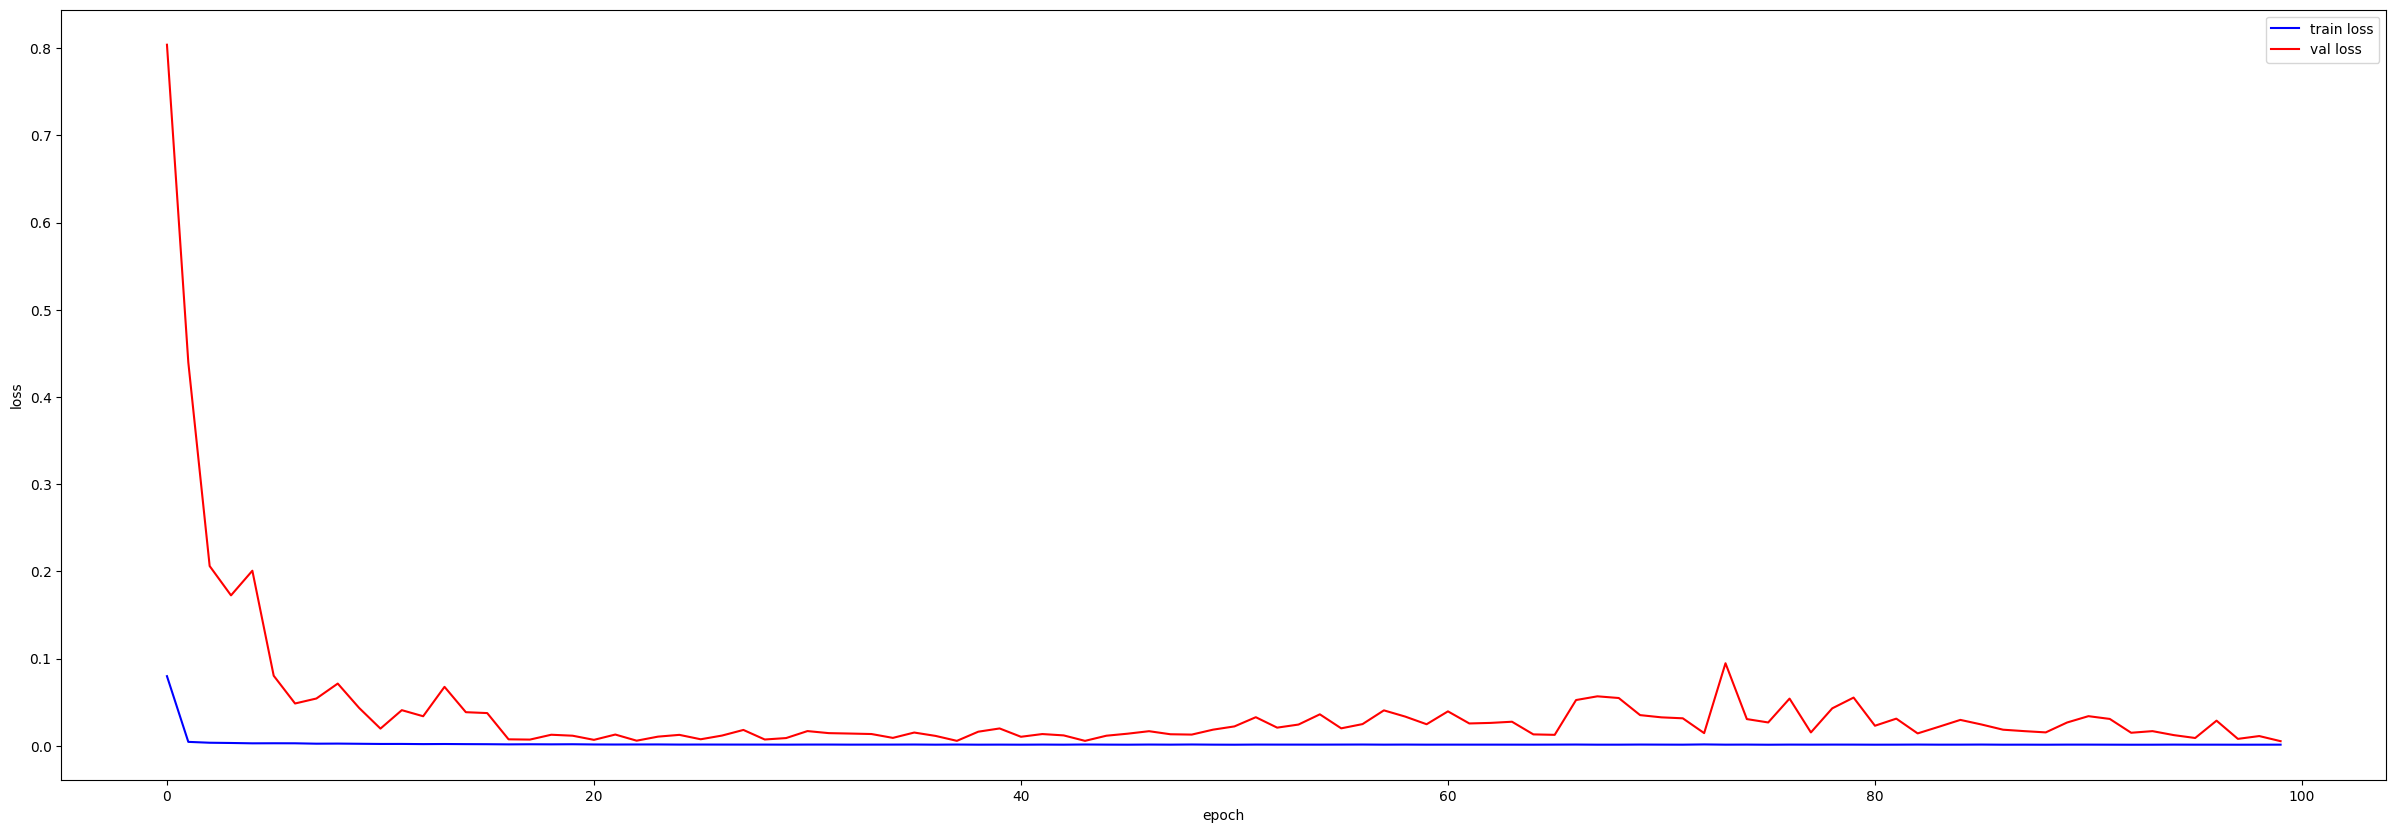

In [24]:
def plot_losses(train_loss,val_loss):
  plt.figure(figsize=(30, 10))
  plt.plot(train_loss,color="blue",label="train loss")
  plt.plot(val_loss,color="red",label="val loss")
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.show()

plot_losses(train_losses,val_losses)

In [25]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            X = X.to(device)
            y_star = model(X)
            output = torch.cat((output, y_star.detach().cpu()), 0)
    return output

In [26]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"

df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_val[ystar_col] = predict(val_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = None
df_test_out = pd.DataFrame()
df_test_out[target] = df_test[target]
df_test_out[ystar_col] = df_test[ystar_col]
df_test_out["Close"] = df_test["Close"]

df_out = pd.concat((df_train, df_val, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

for c in df_test_out.columns:
    df_test_out[c] = df_test_out[c] * target_stdev + target_mean

print(df_test_out[[target, ystar_col,"Close"]])

                           Close_lead1  Model forecast
Date                                                  
2022-05-02 00:00:00-04:00  4175.479980     4165.011719
2022-05-03 00:00:00-04:00  4300.169922     4180.887695
2022-05-04 00:00:00-04:00  4146.870117     4285.627930
2022-05-05 00:00:00-04:00  4123.339844     4205.862305
2022-05-06 00:00:00-04:00  3991.239990     4141.512695
...                                ...             ...
2024-05-03 00:00:00-04:00  5180.740234     5097.610352
2024-05-06 00:00:00-04:00  5187.700195     5157.443848
2024-05-07 00:00:00-04:00  5187.669922     5174.194824
2024-05-08 00:00:00-04:00  5214.080078     5172.444336
2024-05-09 00:00:00-04:00  5222.680176     5190.307129

[509 rows x 2 columns]


In [27]:
df_test_out["diff_pred"] = df_test_out[ystar_col] - df_test_out["Close"]
df_test_out["diff"] = df_test_out[target] - df_test_out["Close"]
df_test_out["diff_pred"].plot(figsize=(20, 7))
df_test_out["diff"].plot(figsize=(20, 7))
plt.legend()
plt.show()

,Open,High,Low,Close,Volume,spy_open,spy_high,spy_low,spy_close,spy_volume,...,msft_close,msft_volume,Close_lead1,volatility,ema_5,ema_10,ema_20,ema_50,ema_100,Model forecast
Date,,,,,,,,,,,,,,,,,,,,,
2022-05-02 00:00:00-04:00,3.837628,3.876049,3.756319,3.877079,1.168110,3.941407,3.971973,3.864498,3.976562,0.205381,...,6.698623,-0.492924,3.907491,5.310513,3.953254,4.054206,4.177844,4.326529,4.479300,3.890746
2022-05-03 00:00:00-04:00,3.884297,3.924393,3.892039,3.909240,0.712710,3.985370,4.016813,3.989712,4.004969,-0.387122,...,6.624061,-0.799684,4.106944,2.030191,3.940556,4.030129,4.154602,4.312635,4.470803,3.916142
2022-05-04 00:00:00-04:00,3.918535,4.096064,3.894976,4.108745,1.146637,4.016324,4.176664,3.994968,4.194550,0.062404,...,6.851349,-0.544821,3.861727,8.419804,3.998669,4.046790,4.152660,4.307201,4.466529,4.083683
2022-05-05 00:00:00-04:00,4.061325,4.036643,3.826129,3.863463,1.100192,4.128028,4.107242,3.930859,3.966545,0.353969,...,6.501269,-0.221721,3.824088,8.762485,3.955556,4.015718,4.127437,4.292249,4.457355,3.956090
2022-05-06 00:00:00-04:00,3.833724,3.856705,3.764985,3.825815,1.131435,3.926902,3.955288,3.875158,3.929615,0.138879,...,6.428649,-0.404994,3.612782,4.251720,3.914251,3.983434,4.101013,4.276390,4.447596,3.853158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-03 00:00:00-04:00,5.424992,5.423114,5.423257,5.432951,0.198347,5.665233,5.653325,5.660827,5.666074,-0.664357,...,10.289483,-1.085020,5.515495,1.116432,5.363152,5.362257,5.398609,5.430416,5.349065,5.382522
2024-05-06 00:00:00-04:00,5.456414,5.489956,5.489375,5.517672,0.009107,5.705190,5.715724,5.734246,5.747517,-0.923502,...,10.483634,-1.100073,5.526628,1.157537,5.417246,5.393493,5.412991,5.437044,5.356039,5.478230
2024-05-07 00:00:00-04:00,5.528057,5.520648,5.548015,5.528808,0.247586,5.763968,5.745848,5.783037,5.756309,-0.869658,...,10.365111,-0.999020,5.526580,0.111433,5.457026,5.421079,5.427068,5.443854,5.363101,5.505025


In [38]:
import numpy as np
import math
from sklearn.metrics import mean_squared_error
def MASE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean(torch.abs(pred - y) / torch.mean(torch.abs(y[1:] - y[:-1]))))

def SMAPE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(200 * torch.mean(torch.abs(pred - y) / (torch.abs(y) + torch.abs(pred))))

def MAE(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean(torch.abs(pred - y)))

def sharp_ratio(pred, y):
    pred = torch.tensor(pred)
    y = torch.tensor(y)
    return float(torch.mean((pred - y) / torch.std(y)))

def directional_accuracy(Y_actual, Y_predicted):
    actual_changes = np.sign(np.diff(Y_actual))
    predicted_changes = np.sign(np.diff(Y_predicted))
    correct_predictions = np.sum(actual_changes == predicted_changes)
    total_predictions = len(actual_changes)
    directional_accuracy = correct_predictions / total_predictions * 100
    return directional_accuracy

# print validation loss

print( 'best_val_loss =', best_val_loss )
# print( 'MSE =', mean_squared_error(df_test_out[target], df_test_out['Model forecast']))
# print( 'MASE =', MASE(df_test_out[target], df_test_out['Model forecast']))
print( 'RMSE =', math.sqrt(mean_squared_error(df_test_out[target], df_test_out['Model forecast'])) )
print( 'SMAPE =', SMAPE(df_test_out[target], df_test_out['Model forecast']))
print( 'MAE =', MAE(df_test_out[target], df_test_out['Model forecast']))
# print( 'sharp_ratio =', sharp_ratio(df_test_out[target], df_test_out['Model forecast']))
print('directional_acc =', directional_accuracy(df_test_out[target], df_test_out['Model forecast']))

best_val_loss = 0.0052103795314906165
RMSE = 50.44129070559749
SMAPE = 0.934937850053092
MAE = 39.11530440354863
directional_acc = 50.196850393700785


In [29]:
fig = px.line(df_out, labels={'value': target, 'created_at': 'Date'})
fig.add_vline(x=val_start, line_width=4, line_dash="dash")
fig.add_vline(x=test_start, line_width=4, line_dash="dash")

pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [30]:
fig = px.line(df_test_out[[target, ystar_col]], labels={'value': target, 'created_at': 'Date'})
pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout({
        "font_size": 18,
        "xaxis_title_font_size": 24,
        "yaxis_title_font_size": 24})
)

fig.update_layout(
  template=plot_template, legend=dict(orientation='h', y=1.02, title_text="")
)
fig.show()

In [31]:
# param_grid = {
#     'dropout_lstm': [0.2],
#     'weight_decay': [1e-4, 1e-5],
#     'learning_rate': [1e-3, 5e-4],
#     'num_lstm_hiddensize': [64],
#     'lstm_layers': [1],
#     'filters': [64],
#     'kernel_size': [3],
#     'bidirectional': [False],
#     'num_consecutive_days': [60],
#     'days_pred': [1],
#     'num_features': [len(features)],
#     'batch_size': [32]
# }

# param_combinations = list(product(*param_grid.values()))
# len(param_combinations)

# best_val_loss = 0.0060552722425200045
# MSE = 0.5731296585740161
# MASE = 2.812599912873599
# RMSE = 473.2795222733895
# SMAPE = 9.46255655450534
# MAE = 400.69768004052065
# sharp_ratio = 1.7605471178394594

# best_val_loss = 0.004956187607604079
# MSE = 2.2562398758289315
# MASE = 1.1129412866842323
# RMSE = 939.039628108167
# SMAPE = 19.207475683146328
# MAE = 789.9090592959541
# sharp_ratio = 0.08195644381471943

In [32]:
def buy_sell_stock_v2(prices,real):
    buy_days = []
    sell_days = []
    current_bought= None
    returns = []
    real_current_bought= None
    real_returns = []
    holding = False  # Flag to indicate if we're holding a stock

    for i in range(len(prices)-1):
        if  holding and real[i] > prices[i + 1] :
            holding = False
            sell_days.append(prices.index[i])
            # Calculating rate of return
            returns.append(((prices[i] - current_bought) / current_bought)+1)
            real_returns.append(((real[i] - real_current_bought) / real_current_bought)+1)

        elif not holding and real[i] < prices[i + 1]:
            buy_days.append(prices.index[i])
            holding = True
            current_bought = prices[i]
            real_current_bought = real[i]

    returns = np.array(returns)
    expected_return = (np.prod(returns)-1)*100
    max_expected_return = (returns.max()-1)*100

    real_returns = np.array(real_returns)
    real_return = (np.prod(real_returns)-1)*100
    max_real_return =(real_returns.max()-1)*100
    return buy_days, sell_days, expected_return,real_return,max_expected_return,max_real_return,returns,real_returns

def plot_stock_prices(prices,real, buy_days, sell_days):
    plt.figure(figsize=(30, 10))
    plt.plot(prices.index, prices.values, label='Pred Stock Prices')
    plt.plot(real.index, real.values, label='Real Stock Prices')
    plt.scatter(buy_days, prices.loc[buy_days], color='green', marker='^', label='Buy')
    plt.scatter(sell_days, prices.loc[sell_days], color='red', marker='v', label='Sell')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Prices with Buy/Sell Signals')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

In [1]:
buy_days, sell_days, expected_return, real_return,max_expected_return,max_real_return,returns,real_returns =  buy_sell_stock_v2( df_test_out['Model forecast'],df_test_out[target] )
# print("expected_return =",expected_return,"%")
print("real_return =",real_return,"%")
# print("max_expected_return =",max_expected_return,"%")
print("max_real_return =",max_real_return,"%")

NameError: name 'buy_sell_stock_v2' is not defined

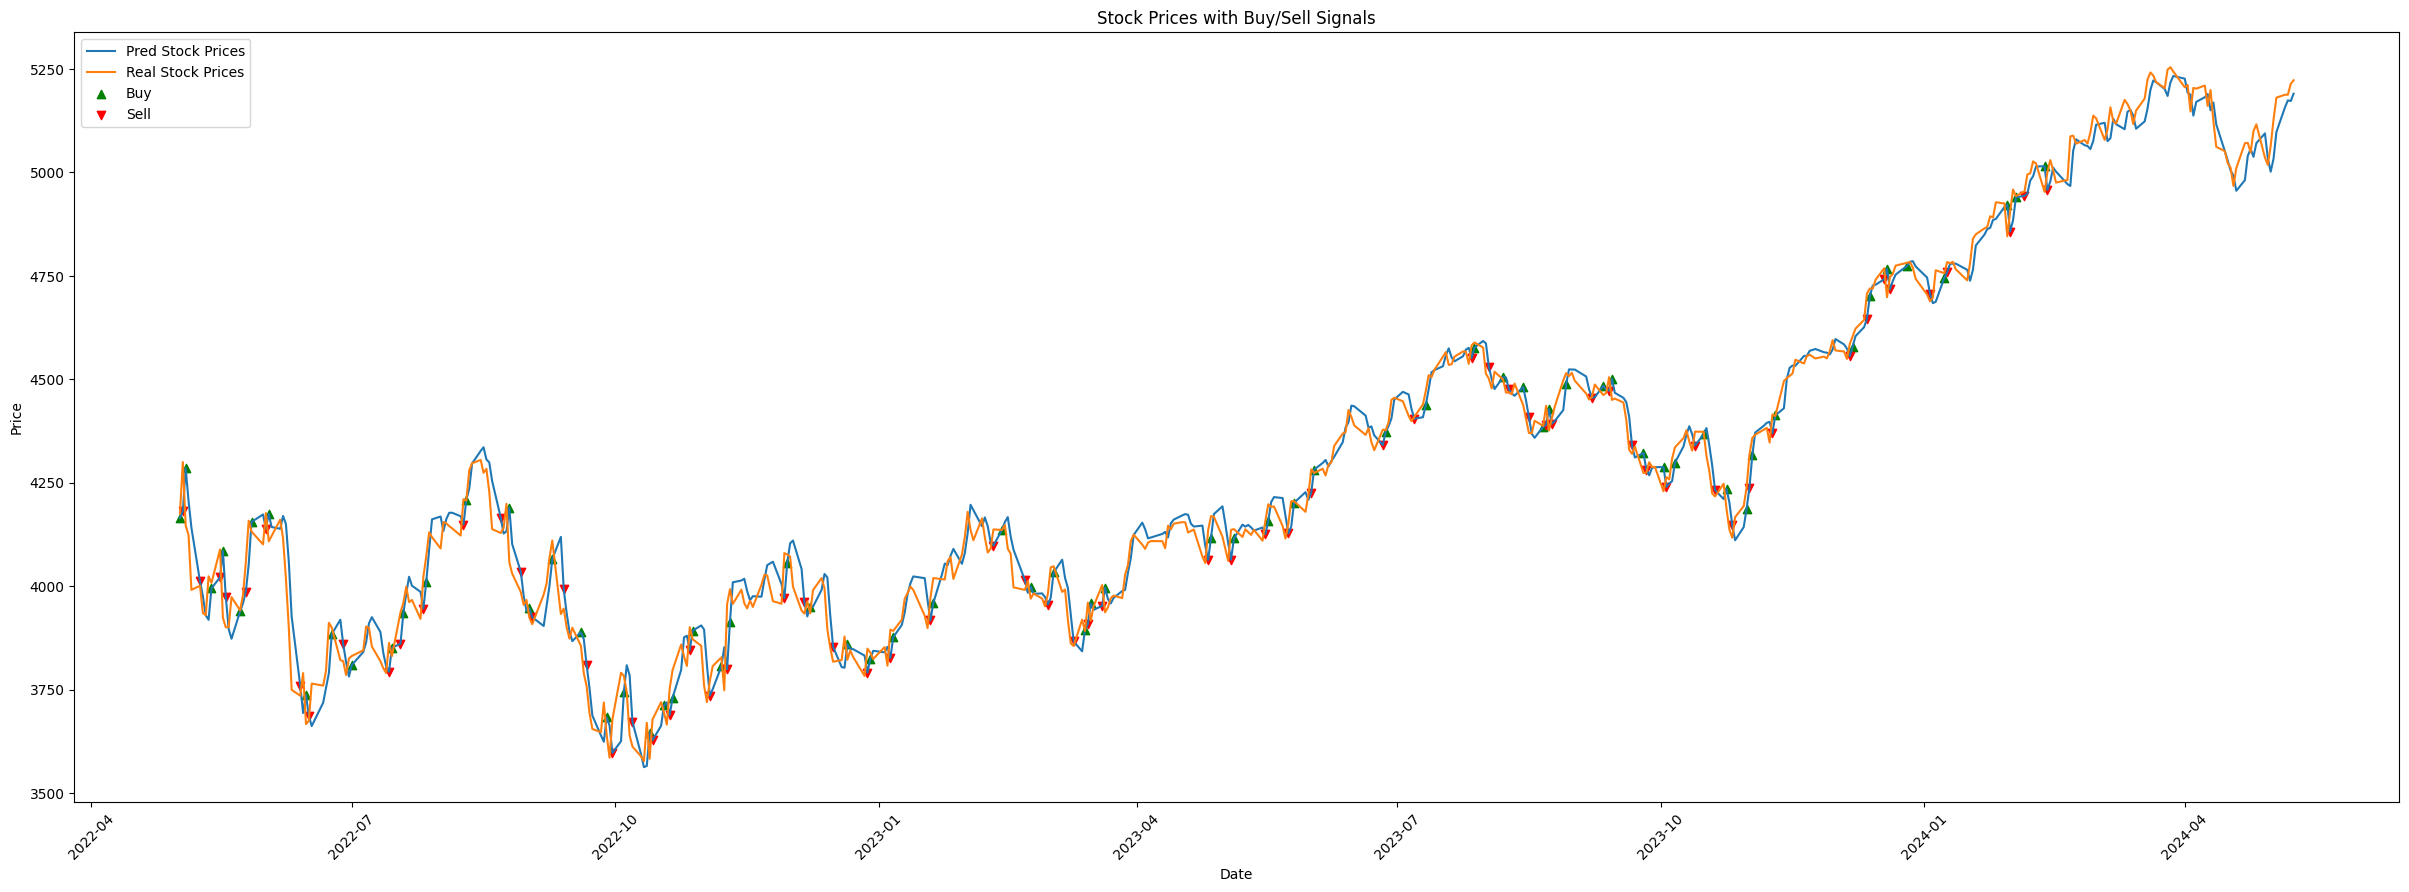

In [34]:
plot_stock_prices( df_test_out['Model forecast'], df_test_out[target], buy_days, sell_days)

In [35]:
def buy_sell_stock(prices,real):
    buy_days = []
    sell_days = []
    current_bought= None
    returns = []
    real_current_bought= None
    real_returns = []
    holding = False  # Flag to indicate if we're holding a stock

    for i in range(1, len(prices)-1):
        if  holding and prices[i] > prices[i - 1] and prices[i] > prices[i + 1]:
            holding = False
            sell_days.append(prices.index[i])
            # Calculating rate of return
            returns.append(((prices[i] - current_bought) / current_bought)+1)
            real_returns.append(((real[i] - real_current_bought) / real_current_bought)+1)

        elif not holding and prices[i] < prices[i - 1] and prices[i] < prices[i + 1]:
            buy_days.append(prices.index[i])
            holding = True
            current_bought = prices[i]
            real_current_bought = real[i]

    returns = np.array(returns)
    expected_return = (np.prod(returns)-1)*100
    max_expected_return = (returns.max()-1)*100

    real_returns = np.array(real_returns)
    real_return = (np.prod(real_returns)-1)*100
    max_real_return =(real_returns.max()-1)*100
    return buy_days, sell_days, expected_return,real_return,max_expected_return,max_real_return,returns,real_returns

In [36]:
buy_days, sell_days, expected_return, real_return,max_expected_return,max_real_return,returns,real_returns =  buy_sell_stock( df_test_out['Model forecast'],df_test_out[target]  )
print("expected_return =",expected_return,"%")
print("real_return =",real_return,"%")
print("max_expected_return =",max_expected_return,"%")
print("max_real_return =",max_real_return,"%")

expected_return = 630.8362617894743 %
real_return = 5.831650211576722 %
max_expected_return = 7.7541783452034 %
max_real_return = 4.332567306803292 %


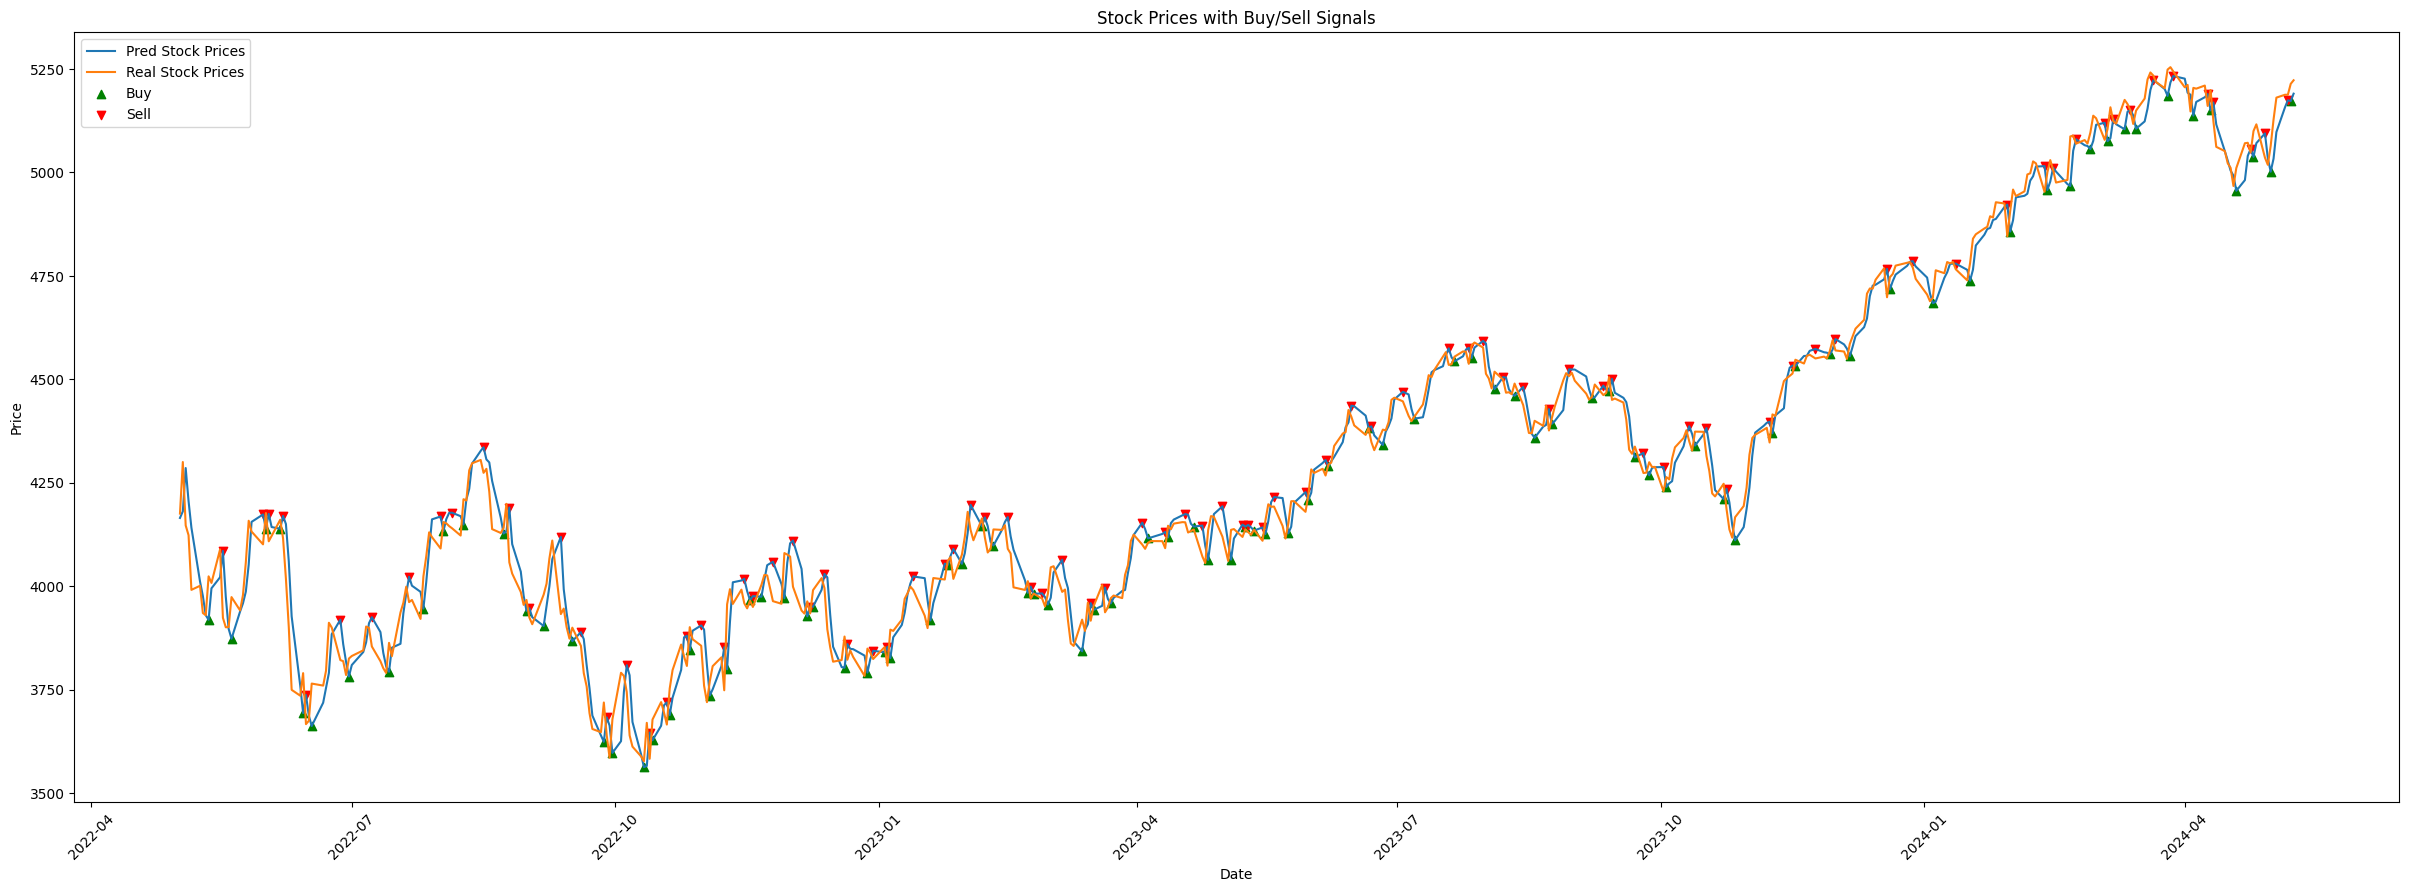

In [37]:
plot_stock_prices(df_test_out['Model forecast'],df_test_out[target] , buy_days, sell_days)

In [ ]:

def grid_search(param_combinations):
    best_val_loss_sin = torch.inf
    best_val_loss_list = []
    best_train_loss_list = []
    best_params = None
    best_val_loss = torch.inf
    best_model = None
    best_train_dataloader = None
    best_val_dataloader = None
    best_test_dataloader = None

    for params in tqdm(param_combinations):
        print(params)
        dropout_lstm, weight_decay, learning_rate, num_lstm_hiddensize, lstm_layers, filters, kernel_size, bidirectional, num_consecutive_days, days_pred, num_features, batch_size, num_epoch = params
        model = ResNLS(num_consecutive_days,
                       days_pred,
                       num_lstm_hiddensize,
                       lstm_layers,
                       num_features,
                       filters,
                       kernel_size,
                       dropout_lstm,
                       bidirectional)
        model.to(device)

        train_dataset = SequenceDataset(
            df_train,
            target=target,
            features=features,
            sequence_length=num_consecutive_days
        )
        val_dataset = SequenceDataset(
            df_val,
            target=target,
            features=features,
            sequence_length=num_consecutive_days
        )
        test_dataset = SequenceDataset(
            df_test,
            target=target,
            features=features,
            sequence_length=num_consecutive_days
        )
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        parameters_to_decay = []
        for name, param in model.named_parameters():
            if 'conv1' in name or 'conv2' in name:
                parameters_to_decay.append(param)

        optimizer = torch.optim.Adam([
            {'params': parameters_to_decay, 'weight_decay': weight_decay},
            {'params': model.lstm.parameters()},
            {'params': model.linear.parameters()}
        ], lr=learning_rate)

        loss_function = nn.MSELoss()

        train_losses = []
        val_losses = []
        for ix_epoch in range(num_epoch):
            print(f"Epoch {ix_epoch}\n---------")
            train_losses.append(train_model(train_loader, model, loss_function, optimizer=optimizer))
            best_val_loss, avg_loss = test_model(val_loader, model, loss_function, best_val_loss)
            val_losses.append(avg_loss)
            print()

        if best_val_loss < best_val_loss_sin:
            best_params = params
            best_val_loss_list = val_losses
            best_train_loss_list = train_losses
            best_val_loss_sin = best_val_loss
            best_train_dataloader = train_loader
            best_val_dataloader = val_loader
            best_test_dataloader = test_loader
            best_model = model

    print(f"Best params: {best_params}")
    print(f"Best val loss: {best_val_loss_sin}")
    plot_losses(best_train_loss_list, best_val_loss_list)

    ystar_col = "Model forecast"

    df_train[ystar_col] = predict(best_train_dataloader, best_model).numpy()
    df_val[ystar_col] = predict(best_val_dataloader, best_model).numpy()
    df_test[ystar_col] = predict(best_test_dataloader, best_model).numpy()

    df_out = None
    df_test_out = pd.DataFrame()
    df_test_out[target] = df_test[target]
    df_test_out[ystar_col] = df_test[ystar_col]

    df_out = pd.concat((df_train, df_val, df_test))[[target, ystar_col]]

    for c in df_out.columns:
        df_out[c] = df_out[c] * target_stdev + target_mean

    for c in df_test_out.columns:
        df_test_out[c] = df_test_out[c] * target_stdev + target_mean

    print(df_test_out[[target, ystar_col]])

    print( 'best_val_loss =', best_val_loss )
    print( 'MSE =', mean_squared_error(df_test_out[target], df_test_out['Model forecast']))
    print( 'MASE =', MASE(df_test_out[target], df_test_out['Model forecast']))
    print( 'RMSE =', math.sqrt(mean_squared_error(df_test_out[target], df_test_out['Model forecast'])) )
    print( 'SMAPE =', SMAPE(df_test_out[target], df_test_out['Model forecast']))
    print( 'MAE =', MAE(df_test_out[target], df_test_out['Model forecast']))
    print( 'sharp_ratio =', sharp_ratio(df_test_out[target], df_test_out['Model forecast']))

    plt.figure(figsize=(20, 7))
    plt.plot(df_test_out[target], label='True')
    plt.plot(df_test_out[ystar_col], label='Forecast')
    plt.legend()

    return best_params

def copy_from_best(best_params):
    dropout_lstm, weight_decay, learning_rate, num_lstm_hiddensize, lstm_layers, filters, kernel_size, bidirectional, num_consecutive_days, days_pred, num_features, batch_size, num_epoch = best_params
    param_grid = {
      'dropout_lstm': [dropout_lstm],
      'weight_decay': [weight_decay],
      'learning_rate': [learning_rate],
      'num_lstm_hiddensize': [num_lstm_hiddensize],
      'lstm_layers': [lstm_layers],
      'filters': [filters],
      'kernel_size': [kernel_size],
      'bidirectional': [bidirectional],
      'num_consecutive_days': [num_consecutive_days],
      'days_pred': [days_pred],
      'num_features': [num_features],
      'batch_size': [batch_size],
      'num_epoch': [num_epoch]
    }
    return param_grid


In [ ]:
param_grid = {
    'dropout_lstm': [dropout_lstm],
    'weight_decay': [weight_decay],
    'learning_rate': [learning_rate],
    'num_lstm_hiddensize': [num_lstm_hiddensize],
    'lstm_layers': [lstm_layers],
    'filters': [filters],
    'kernel_size': [kernel_size],
    'bidirectional': [bidirectional],
    'num_consecutive_days': [num_consecutive_days],
    'days_pred': [days_pred],
    'num_features': [num_features],
    'batch_size': [batch_size],
    'num_epoch': [num_epoch]
}
# param_combinations = list(product(*param_grid.values()))[0]

  0%|          | 0/1 [00:00<?, ?it/s]

(0.0, 1e-05, 0.001, 256, 2, 32, 3, False, 120, 1, 1, 32, 300)
Epoch 0
---------
Train loss: 0.06790939927844691
Test loss: 0.505780836509075
Save new best model

Epoch 1
---------
Train loss: 0.003935915315166987
Test loss: 0.1785147200571373
Save new best model

Epoch 2
---------
Train loss: 0.003324360562762576
Test loss: 0.19702299451455474

Epoch 3
---------
Train loss: 0.0030257061993207543
Test loss: 0.05754039136809297
Save new best model

Epoch 4
---------
Train loss: 0.0025116970918456754
Test loss: 0.02777803168282844
Save new best model

Epoch 5
---------
Train loss: 0.0026104530557096305
Test loss: 0.21624578488990664

Epoch 6
---------
Train loss: 0.002419346595659942
Test loss: 0.03722491319058463

Epoch 7
---------
Train loss: 0.0022856248824316408
Test loss: 0.033350245183100924

Epoch 8
---------
Train loss: 0.002318027326011009
Test loss: 0.051460785121889785

Epoch 9
---------
Train loss: 0.0017778407646185388
Test loss: 0.06650589598575607

Epoch 10
---------
Train 

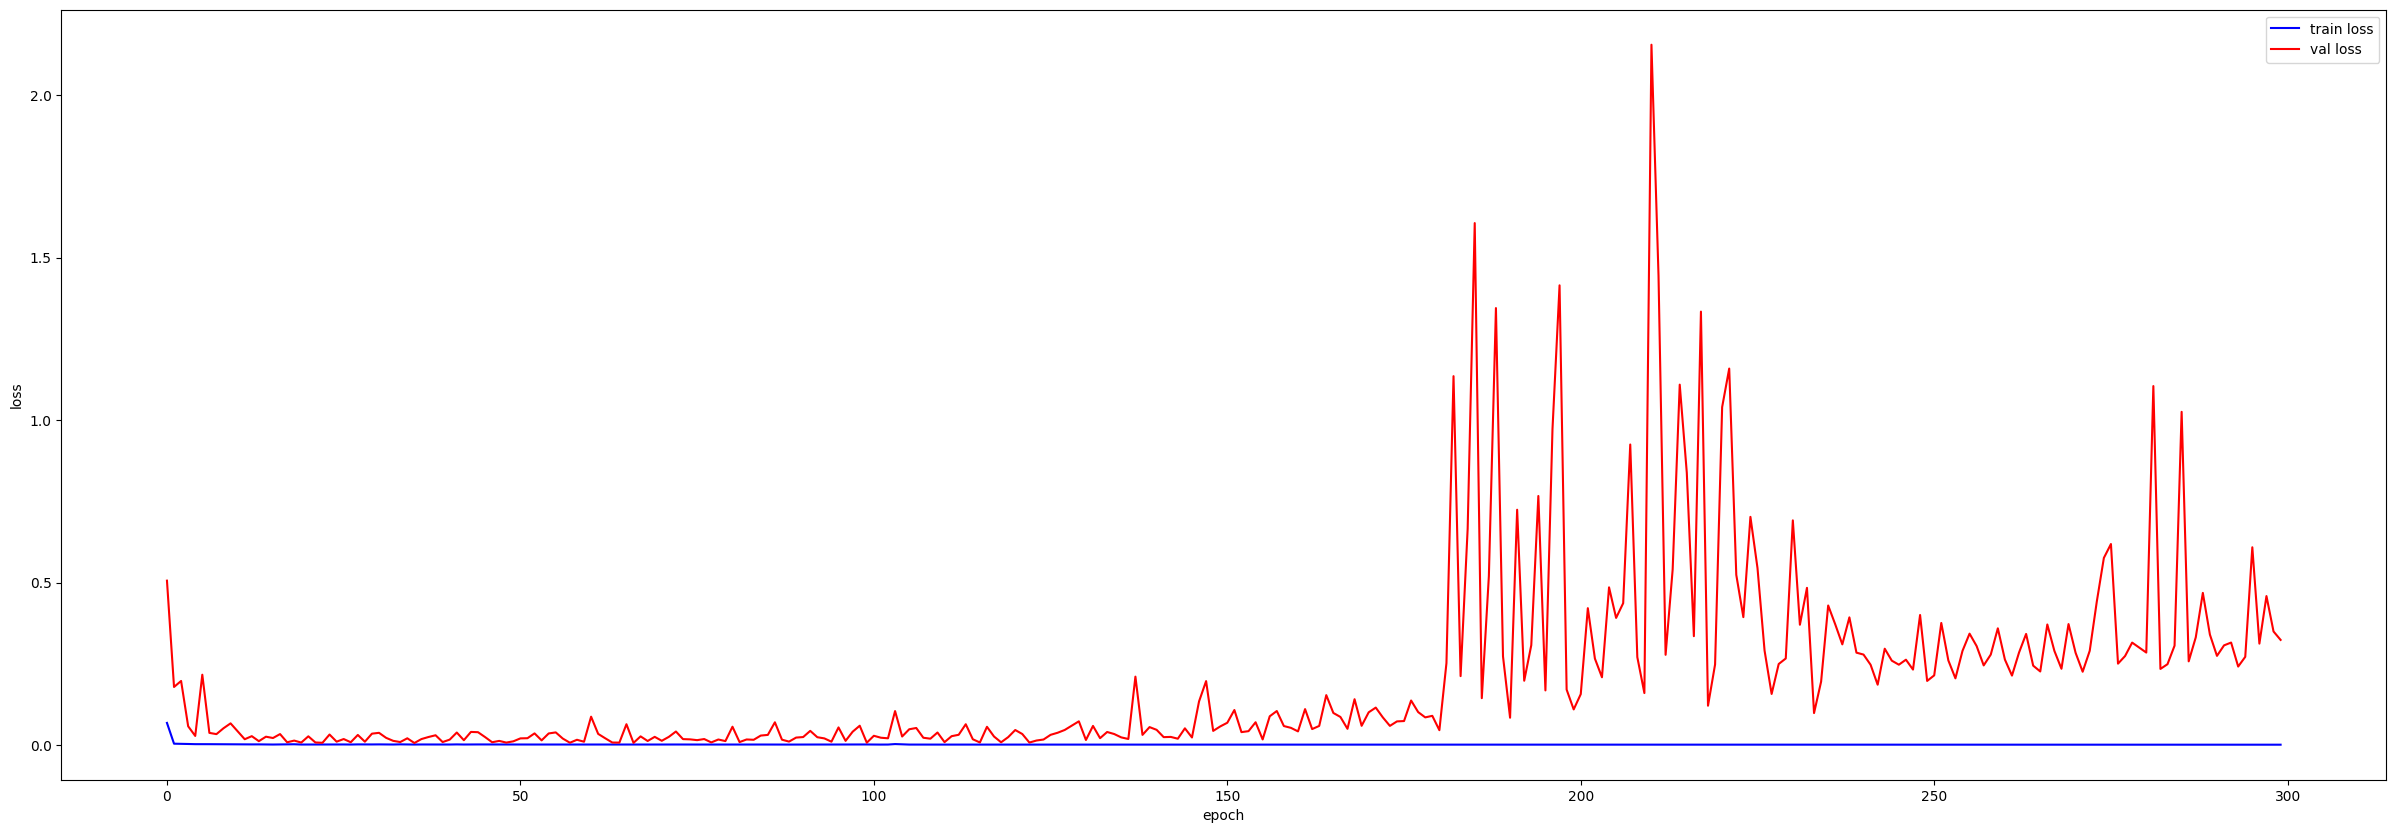

                           Close_lead1  Model forecast
Date                                                  
2022-05-02 00:00:00-04:00  4175.479980     3856.792969
2022-05-03 00:00:00-04:00  4300.169922     3891.727539
2022-05-04 00:00:00-04:00  4146.870117     4058.632568
2022-05-05 00:00:00-04:00  4123.339844     3421.880127
2022-05-06 00:00:00-04:00  3991.239990     4023.000977
...                                ...             ...
2024-05-03 00:00:00-04:00  5180.740234     4270.161621
2024-05-06 00:00:00-04:00  5187.700195     4262.774414
2024-05-07 00:00:00-04:00  5187.669922     4204.133789
2024-05-08 00:00:00-04:00  5214.080078     4243.877930
2024-05-09 00:00:00-04:00  5222.680176     4302.695312

[509 rows x 2 columns]
best_val_loss = 0.0060552722425200045
MSE = 0.5731296585740161
MASE = 2.812599912873599
RMSE = 473.2795222733895
SMAPE = 9.46255655450534
MAE = 400.69768004052065
sharp_ratio = 1.7605471178394594
dropout_lstm: 0.0
weight_decay: 1e-05
learning_rate: 0.001
num_ls

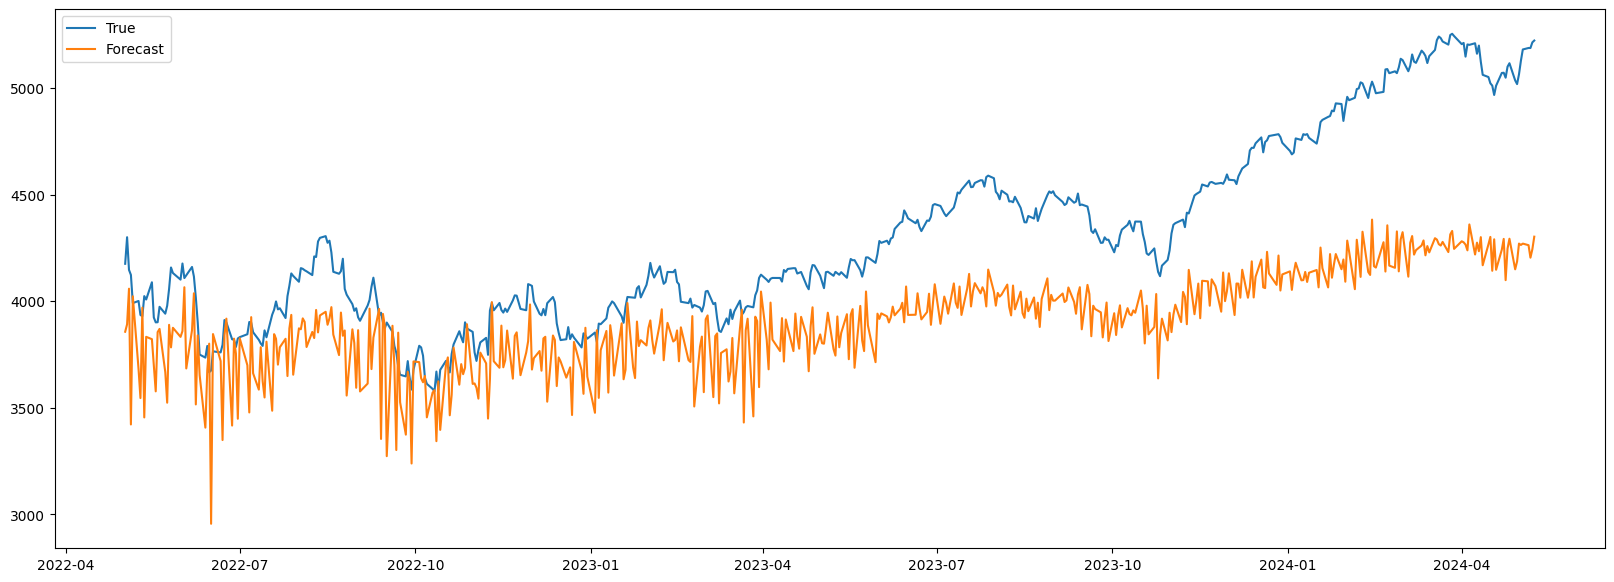

In [ ]:
# param_grid = copy_from_best(list(product(*param_grid.values()))[0])
# # param_grid['weight_decay'] = [1e-4, 1e-5]
# # param_grid['learning_rate'] = [1e-3,5e-4]
# param_grid['num_epoch'] = [300]
# param_combinations = list(product(*param_grid.values()))
# best_params = grid_search(param_combinations)
# param_grid = copy_from_best(best_params)
# for key, value in param_grid.items():
#     print(f"{key}: {value[0]}")

In [ ]:
# param_grid = copy_from_best(best_params)
# param_grid['bidirectional'] = [False]
# param_combinations = list(product(*param_grid.values()))
# best_params = grid_search(param_combinations)

# param_grid = copy_from_best(best_params)
# for key, value in param_grid.items():
#     print(f"{key}: {value[0]}")

In [ ]:
# param_grid = copy_from_best(best_params)
# param_grid['num_consecutive_days'] = [120, 180, 365]
# param_combinations = list(product(*param_grid.values()))
# best_params = grid_search(param_combinations)

# param_grid = copy_from_best(best_params)
# for key, value in param_grid.items():
#     print(f"{key}: {value[0]}")

NameError: name 'copy_from_best' is not defined

In [ ]:
# param_grid = copy_from_best(best_params)
# param_grid['num_lstm_hiddensize'] = [64, 128, 256, 512]
# param_combinations = list(product(*param_grid.values()))
# best_params = grid_search(param_combinations)

# param_grid = copy_from_best(best_params)
# for key, value in param_grid.items():
#     print(f"{key}: {value[0]}")

  0%|          | 0/6 [00:00<?, ?it/s]

(0.0, 1e-05, 0.001, 256, 1, 64, 3, False, 120, 1, 1, 32, 100)
Epoch 0
---------
Train loss: 0.06913542068721126
Test loss: 0.5593967270106077
Save new best model

Epoch 1
---------
Train loss: 0.003707747619163485
Test loss: 0.2005269500077702
Save new best model

Epoch 2
---------
Train loss: 0.0033627090611374907
Test loss: 0.18581490576616488
Save new best model

Epoch 3
---------
Train loss: 0.003195342038393832
Test loss: 0.09879350083065219
Save new best model

Epoch 4
---------
Train loss: 0.0030222065707353214
Test loss: 0.09376451052958146
Save new best model

Epoch 5
---------
Train loss: 0.0024604279082737894
Test loss: 0.152663184562698

Epoch 6
---------
Train loss: 0.0027324179696264646
Test loss: 0.07832393719581887
Save new best model

Epoch 7
---------
Train loss: 0.002305211922747173
Test loss: 0.07862546236719936

Epoch 8
---------
Train loss: 0.0022716555418634426
Test loss: 0.062080743606202304
Save new best model

Epoch 9
---------
Train loss: 0.002190537783580141

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.07184505885496976
Test loss: 0.5563646986847743

Epoch 1
---------
Train loss: 0.0038788983886573285
Test loss: 0.1763408899132628

Epoch 2
---------
Train loss: 0.003582737688820118
Test loss: 0.13914867865969427

Epoch 3
---------
Train loss: 0.002847619972477156
Test loss: 0.05694845604011789

Epoch 4
---------
Train loss: 0.002615271533291126
Test loss: 0.11367772868834436

Epoch 5
---------
Train loss: 0.0027820108479054105
Test loss: 0.041786122441408224

Epoch 6
---------
Train loss: 0.0024462320762986857
Test loss: 0.036883065360598266

Epoch 7
---------
Train loss: 0.002387886078307225
Test loss: 0.023031752760289237

Epoch 8
---------
Train loss: 0.002112844006455083
Test loss: 0.04987411852926016

Epoch 9
---------
Train loss: 0.0020335442602499236
Test loss: 0.04587978246854618

Epoch 10
---------
Train loss: 0.0020818952644701986
Test loss: 0.02421083828085102

Epoch 11
---------
Train loss: 0.001987127882462265
Test loss: 0.030831547890556976

Epoch 12
-----

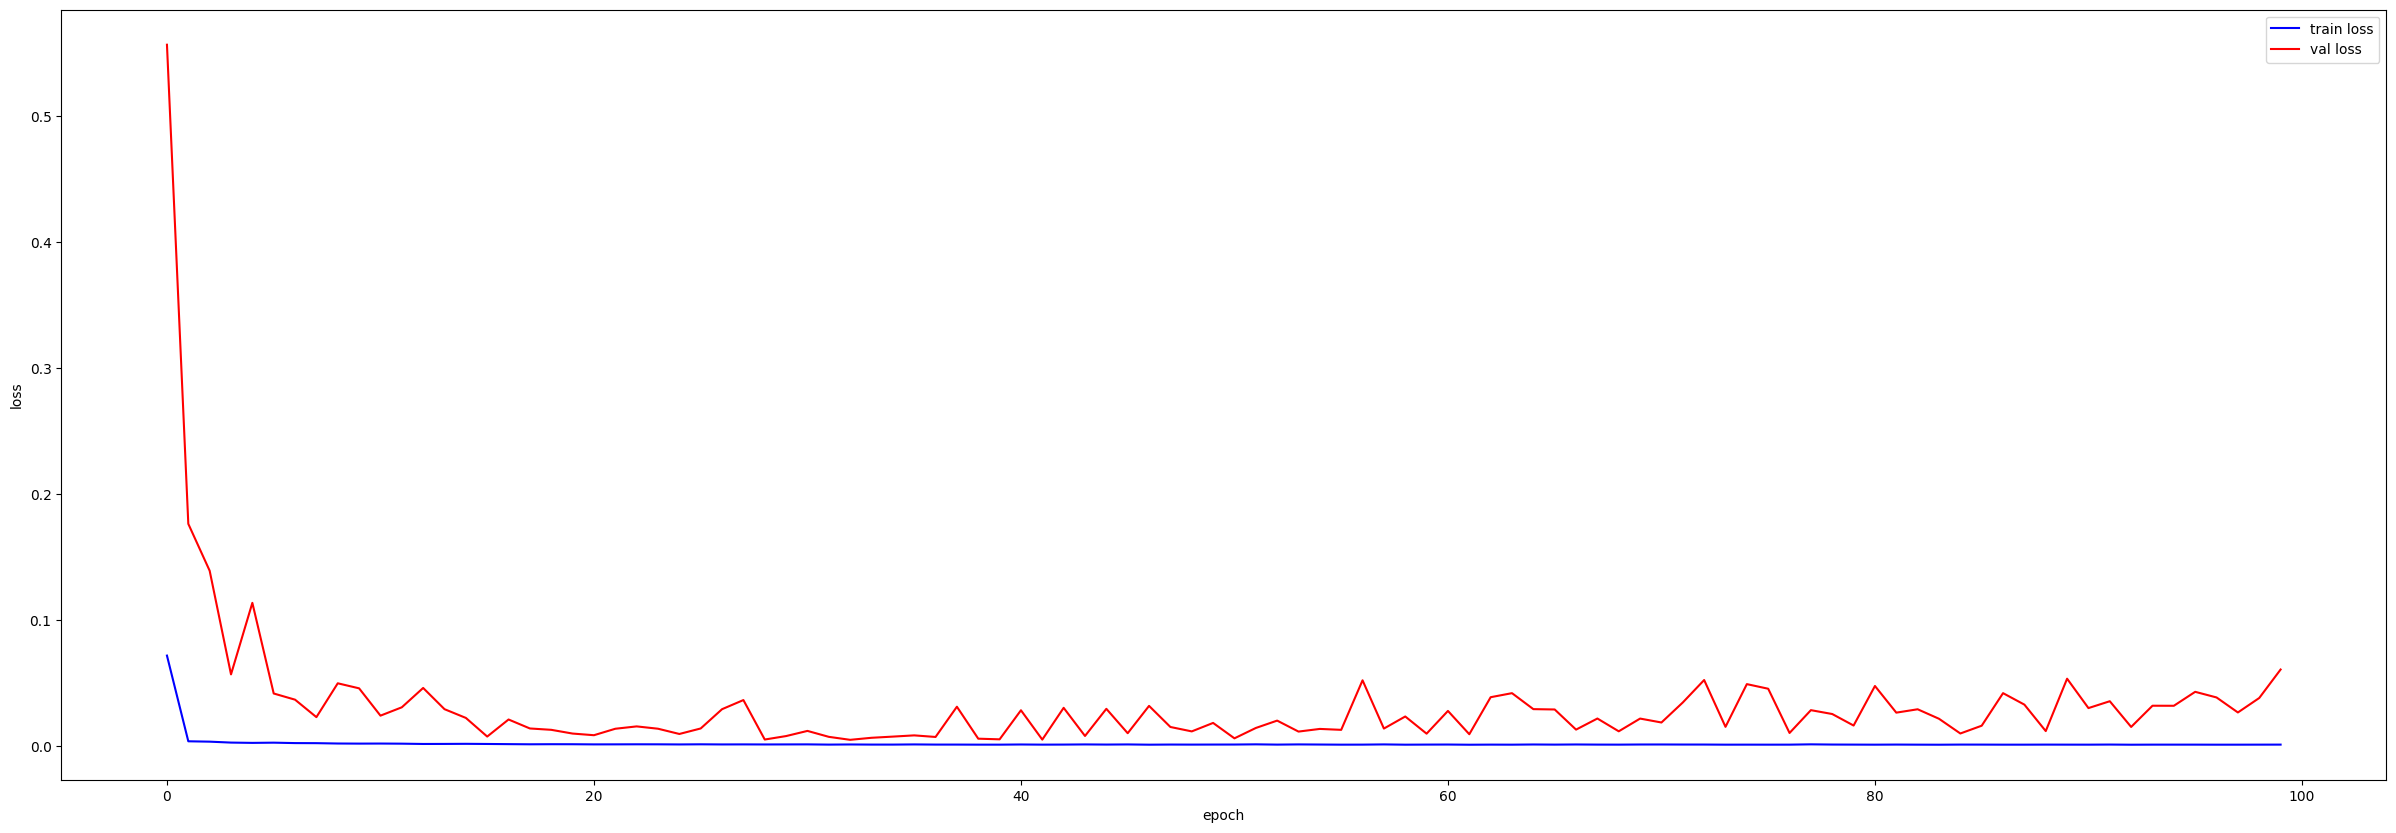

                           Close_lead1  Model forecast
Date                                                  
2022-05-02 00:00:00-04:00  4175.479980     4012.115723
2022-05-03 00:00:00-04:00  4300.169922     4028.122314
2022-05-04 00:00:00-04:00  4146.870117     4130.713867
2022-05-05 00:00:00-04:00  4123.339844     4029.743408
2022-05-06 00:00:00-04:00  3991.239990     3976.622314
...                                ...             ...
2024-05-03 00:00:00-04:00  5180.740234     4808.396484
2024-05-06 00:00:00-04:00  5187.700195     4857.561035
2024-05-07 00:00:00-04:00  5187.669922     4863.301270
2024-05-08 00:00:00-04:00  5214.080078     4858.297852
2024-05-09 00:00:00-04:00  5222.680176     4876.256836

[509 rows x 2 columns]
best_val_loss = 0.005035900016082451
MSE = 0.09620657664017089
MASE = 5.879011438355251
RMSE = 193.90706337812588
SMAPE = 4.00469560108772
MAE = 173.9096463846083
sharp_ratio = 0.4930640370475395
dropout_lstm: 0.2
weight_decay: 1e-05
learning_rate: 0.001
num_ls

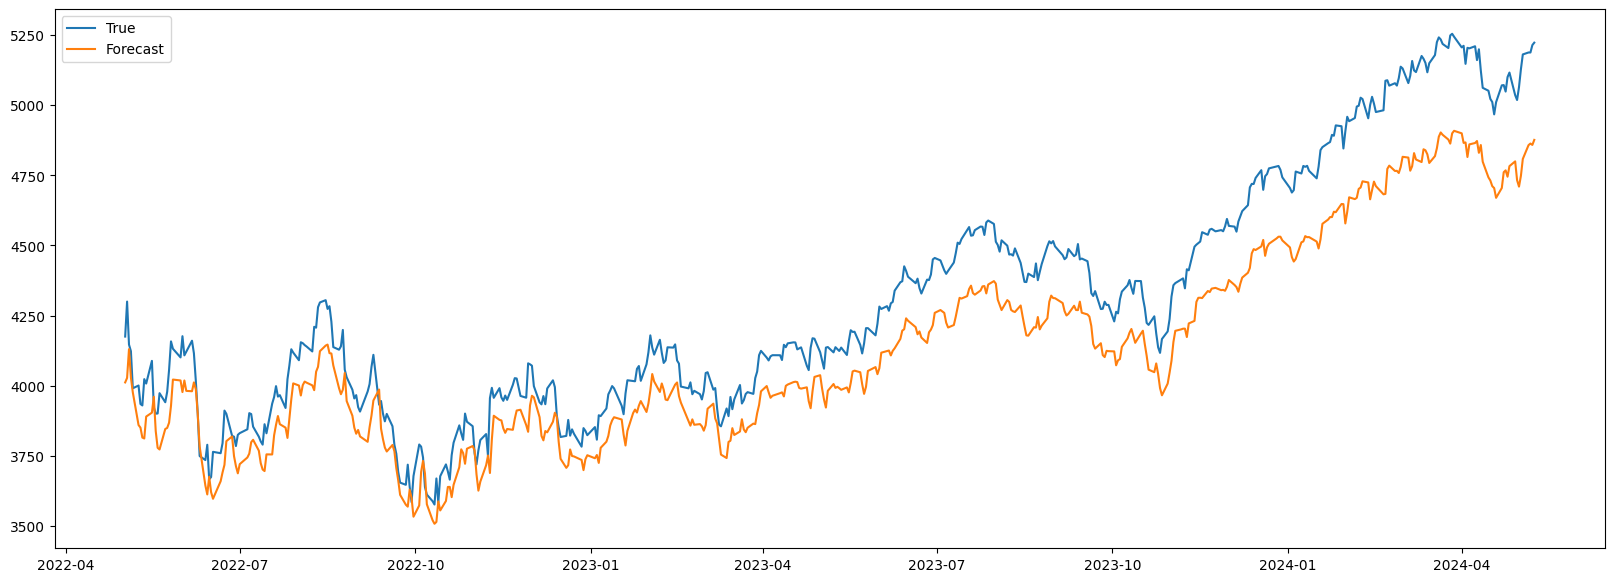

In [ ]:
# param_grid = copy_from_best(best_params)
# param_grid['lstm_layers'] = [1, 3, 5]
# param_grid['dropout_lstm'] = [0.0, 0.2]
# param_combinations = list(product(*param_grid.values()))
# best_params = grid_search(param_combinations)

# param_grid = copy_from_best(best_params)
# for key, value in param_grid.items():
#     print(f"{key}: {value[0]}")

  0%|          | 0/54 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Train loss: 0.0035917160881405335
Test loss: 0.1378398899687454

Epoch 3
---------
Train loss: 0.003463600079187252
Test loss: 0.06343884670059197

Epoch 4
---------
Train loss: 0.002917758683906868
Test loss: 0.013111069551086985

Epoch 5
---------
Train loss: 0.0029564777294346584
Test loss: 0.03436746467195917

Epoch 6
---------
Train loss: 0.0020075206562215763
Test loss: 0.01994003234722186

Epoch 7
---------
Train loss: 0.002090303631003706
Test loss: 0.02047986874822527

Epoch 8
---------
Train loss: 0.0020620560483826746
Test loss: 0.015899599631666206

Epoch 9
---------
Train loss: 0.0018001373471399288
Test loss: 0.0286590255855117

Epoch 10
---------
Train loss: 0.0017948352655249408
Test loss: 0.0881953442003578

Epoch 11
---------
Train loss: 0.002179212281912295
Test loss: 0.011710447448422201

Epoch 12
---------
Train loss: 0.0016095367482780749
Test loss: 0.019197672052541748

Epoch 13
---------
Train loss: 0.0016527006

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.07151672773573908
Test loss: 0.46156068961136043

Epoch 1
---------
Train loss: 0.0032146367307324263
Test loss: 0.22769758256617934

Epoch 2
---------
Train loss: 0.0031264302139583553
Test loss: 0.1416789773502387

Epoch 3
---------
Train loss: 0.002735856474065522
Test loss: 0.09077660899492912

Epoch 4
---------
Train loss: 0.0024400968574017526
Test loss: 0.06935759837506339

Epoch 5
---------
Train loss: 0.002523031321846159
Test loss: 0.023841957823606208

Epoch 6
---------
Train loss: 0.002414111675593191
Test loss: 0.056620294228196144

Epoch 7
---------
Train loss: 0.0021739651396450017
Test loss: 0.08651281584752724

Epoch 8
---------
Train loss: 0.0020899545573141247
Test loss: 0.04989682091400027

Epoch 9
---------
Train loss: 0.0020649201788699193
Test loss: 0.03849543532123789

Epoch 10
---------
Train loss: 0.0019114601684944524
Test loss: 0.01963714591693133

Epoch 11
---------
Train loss: 0.0019919977909716355
Test loss: 0.03519742516800761

Epoch 12
---

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.06263992325928543
Test loss: 0.39247392377001233

Epoch 1
---------
Train loss: 0.00491239549779904
Test loss: 0.24701703514438123

Epoch 2
---------
Train loss: 0.0029791532170718475
Test loss: 0.12477219855645671

Epoch 3
---------
Train loss: 0.0028455902159499427
Test loss: 0.07606755271262955

Epoch 4
---------
Train loss: 0.0028013838398750993
Test loss: 0.10331171617144719

Epoch 5
---------
Train loss: 0.0027431561663228596
Test loss: 0.056243457685923204

Epoch 6
---------
Train loss: 0.002263887979713599
Test loss: 0.0738732740865089

Epoch 7
---------
Train loss: 0.002158108753651651
Test loss: 0.14607289712876081

Epoch 8
---------
Train loss: 0.0022949743992461253
Test loss: 0.035566717910114676

Epoch 9
---------
Train loss: 0.0024700483556972038
Test loss: 0.025296707724919543

Epoch 10
---------
Train loss: 0.001955789804454863
Test loss: 0.0266492769587785

Epoch 11
---------
Train loss: 0.0022630256674845794
Test loss: 0.031165098742349073

Epoch 12
----

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.07577752060962901
Test loss: 0.6599573811981827

Epoch 1
---------
Train loss: 0.004161710181975768
Test loss: 0.38590169907547534

Epoch 2
---------
Train loss: 0.003430290038757507
Test loss: 0.1716691575711593

Epoch 3
---------
Train loss: 0.003282997793810923
Test loss: 0.05918060115072876

Epoch 4
---------
Train loss: 0.0024740499741916036
Test loss: 0.03553228150121868

Epoch 5
---------
Train loss: 0.002466756770680208
Test loss: 0.022921372787095606

Epoch 6
---------
Train loss: 0.0023756056621242615
Test loss: 0.0947089558467269

Epoch 7
---------
Train loss: 0.0025552956940373406
Test loss: 0.05437656588037498

Epoch 8
---------
Train loss: 0.002301241760799331
Test loss: 0.0500701128912624

Epoch 9
---------
Train loss: 0.002121143154762385
Test loss: 0.026213715798803605

Epoch 10
---------
Train loss: 0.002027054451079288
Test loss: 0.023661094994167797

Epoch 11
---------
Train loss: 0.0019073576418562762
Test loss: 0.00973674890701659

Epoch 12
---------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.07619651142440195
Test loss: 0.7630236035911366

Epoch 1
---------
Train loss: 0.004326982913734091
Test loss: 0.426560588151915

Epoch 2
---------
Train loss: 0.0034316694622130825
Test loss: 0.3002162167103961

Epoch 3
---------
Train loss: 0.0036706285341830563
Test loss: 0.3504607295617461

Epoch 4
---------
Train loss: 0.0030449703471892844
Test loss: 0.10249691345961764

Epoch 5
---------
Train loss: 0.0024296138895630475
Test loss: 0.08451177668757737

Epoch 6
---------
Train loss: 0.002686571646688296
Test loss: 0.06690667243674397

Epoch 7
---------
Train loss: 0.0023074413848301065
Test loss: 0.03456417439156212

Epoch 8
---------
Train loss: 0.002388492935654452
Test loss: 0.08552433963632211

Epoch 9
---------
Train loss: 0.002149723143027645
Test loss: 0.05424257037520874

Epoch 10
---------
Train loss: 0.0020437219772570497
Test loss: 0.043536188575671986

Epoch 11
---------
Train loss: 0.001820178617509232
Test loss: 0.04758559912443161

Epoch 12
---------


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.08951014299659178
Test loss: 0.8113832637900487

Epoch 1
---------
Train loss: 0.003560654319082988
Test loss: 0.382335449277889

Epoch 2
---------
Train loss: 0.0031674065600870356
Test loss: 0.30376596841961145

Epoch 3
---------
Train loss: 0.0029515015405430006
Test loss: 0.09474597124790307

Epoch 4
---------
Train loss: 0.0028549404014484026
Test loss: 0.08510611861129291

Epoch 5
---------
Train loss: 0.002682704369128201
Test loss: 0.06312877428717911

Epoch 6
---------
Train loss: 0.0024423102961830616
Test loss: 0.10449497075751424

Epoch 7
---------
Train loss: 0.0023041968994338305
Test loss: 0.07691327040083706

Epoch 8
---------
Train loss: 0.0024248951292153626
Test loss: 0.0369246907212073

Epoch 9
---------
Train loss: 0.0021144404111715456
Test loss: 0.056403488328214735

Epoch 10
---------
Train loss: 0.0019442722930820778
Test loss: 0.025956801066058688

Epoch 11
---------
Train loss: 0.0020710566905402248
Test loss: 0.06494267337257043

Epoch 12
-----

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.08402407467139945
Test loss: 0.7690770938061178

Epoch 1
---------
Train loss: 0.0034631240320572207
Test loss: 0.2588756286422722

Epoch 2
---------
Train loss: 0.003179351111494696
Test loss: 0.190618052467471

Epoch 3
---------
Train loss: 0.002787974743818444
Test loss: 0.17482732934877276

Epoch 4
---------
Train loss: 0.0029672566104695323
Test loss: 0.06647492130286992

Epoch 5
---------
Train loss: 0.0026492320363514965
Test loss: 0.06863292676280253

Epoch 6
---------
Train loss: 0.0023543031918140307
Test loss: 0.10568032879382372

Epoch 7
---------
Train loss: 0.002307100185839039
Test loss: 0.05066155601525679

Epoch 8
---------
Train loss: 0.0022205802214880204
Test loss: 0.06334609378245659

Epoch 9
---------
Train loss: 0.002090920074073027
Test loss: 0.017257658997550607

Epoch 10
---------
Train loss: 0.002074143405714553
Test loss: 0.035099032043945044

Epoch 11
---------
Train loss: 0.0021590875999649025
Test loss: 0.04954910301603377

Epoch 12
--------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.07268562058649672
Test loss: 0.732416084734723

Epoch 1
---------
Train loss: 0.004136851750269172
Test loss: 0.4413129179738462

Epoch 2
---------
Train loss: 0.003348145506724024
Test loss: 0.32013201888184994

Epoch 3
---------
Train loss: 0.0030538481955919715
Test loss: 0.14638548558286857

Epoch 4
---------
Train loss: 0.0028549185043366086
Test loss: 0.12449638778343797

Epoch 5
---------
Train loss: 0.0030313147736089905
Test loss: 0.12559196958318353

Epoch 6
---------
Train loss: 0.0024972604695639965
Test loss: 0.08210224460344762

Epoch 7
---------
Train loss: 0.0024138788984630318
Test loss: 0.05595502626965754

Epoch 8
---------
Train loss: 0.0021260994901475044
Test loss: 0.01859312315355055

Epoch 9
---------
Train loss: 0.002137380702591937
Test loss: 0.05004657985409722

Epoch 10
---------
Train loss: 0.0020757019585524233
Test loss: 0.09757457149680704

Epoch 11
---------
Train loss: 0.0020384316017190295
Test loss: 0.03290362075495068

Epoch 12
-------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Train loss: 0.06296912142105641
Test loss: 0.4137234676454682

Epoch 1
---------
Train loss: 0.0037078750197730597
Test loss: 0.21369091130327433

Epoch 2
---------
Train loss: 0.0034504770634568205
Test loss: 0.08355181140359491

Epoch 3
---------
Train loss: 0.0030039671419804254
Test loss: 0.13778520782943815

Epoch 4
---------
Train loss: 0.0027219210380515562
Test loss: 0.0978733460069634

Epoch 5
---------
Train loss: 0.002366779709137195
Test loss: 0.05674720834940672

Epoch 6
---------
Train loss: 0.0022630772436968982
Test loss: 0.0400602143490687

Epoch 7
---------
Train loss: 0.002254765303786694
Test loss: 0.03474681274383329

Epoch 8
---------
Train loss: 0.002050715622082803
Test loss: 0.035778349032625556

Epoch 9
---------
Train loss: 0.0021690478334353575
Test loss: 0.043089309183415025

Epoch 10
---------
Train loss: 0.001978406960270443
Test loss: 0.03726877842564136

Epoch 11
---------
Train loss: 0.001976779240067117
Test loss: 0.10220407892484218

Epoch 12
-------

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning:

dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1



Streaming output truncated to the last 5000 lines.
---------
Train loss: 0.0037341734681714087
Test loss: 0.1018455449375324

Epoch 3
---------
Train loss: 0.003381923563973678
Test loss: 0.10622309820610099

Epoch 4
---------
Train loss: 0.0034355651207020384
Test loss: 0.06883289090183098

Epoch 5
---------
Train loss: 0.0031923870002144887
Test loss: 0.05888315264019184

Epoch 6
---------
Train loss: 0.0030332257653841927
Test loss: 0.06746766084688716

Epoch 7
---------
Train loss: 0.0034343935516400023
Test loss: 0.15064623882062733

Epoch 8
---------
Train loss: 0.0026571354777139102
Test loss: 0.0866670191171579

Epoch 9
---------
Train loss: 0.0032582896031183944
Test loss: 0.0849149405839853

Epoch 10
---------
Train loss: 0.002918374438811424
Test loss: 0.04857454830198549

Epoch 11
---------
Train loss: 0.002654613996949798
Test loss: 0.1163844492402859

Epoch 12
---------
Train loss: 0.0023553970320555834
Test loss: 0.16867098631337285

Epoch 13
---------
Train loss: 0.0023

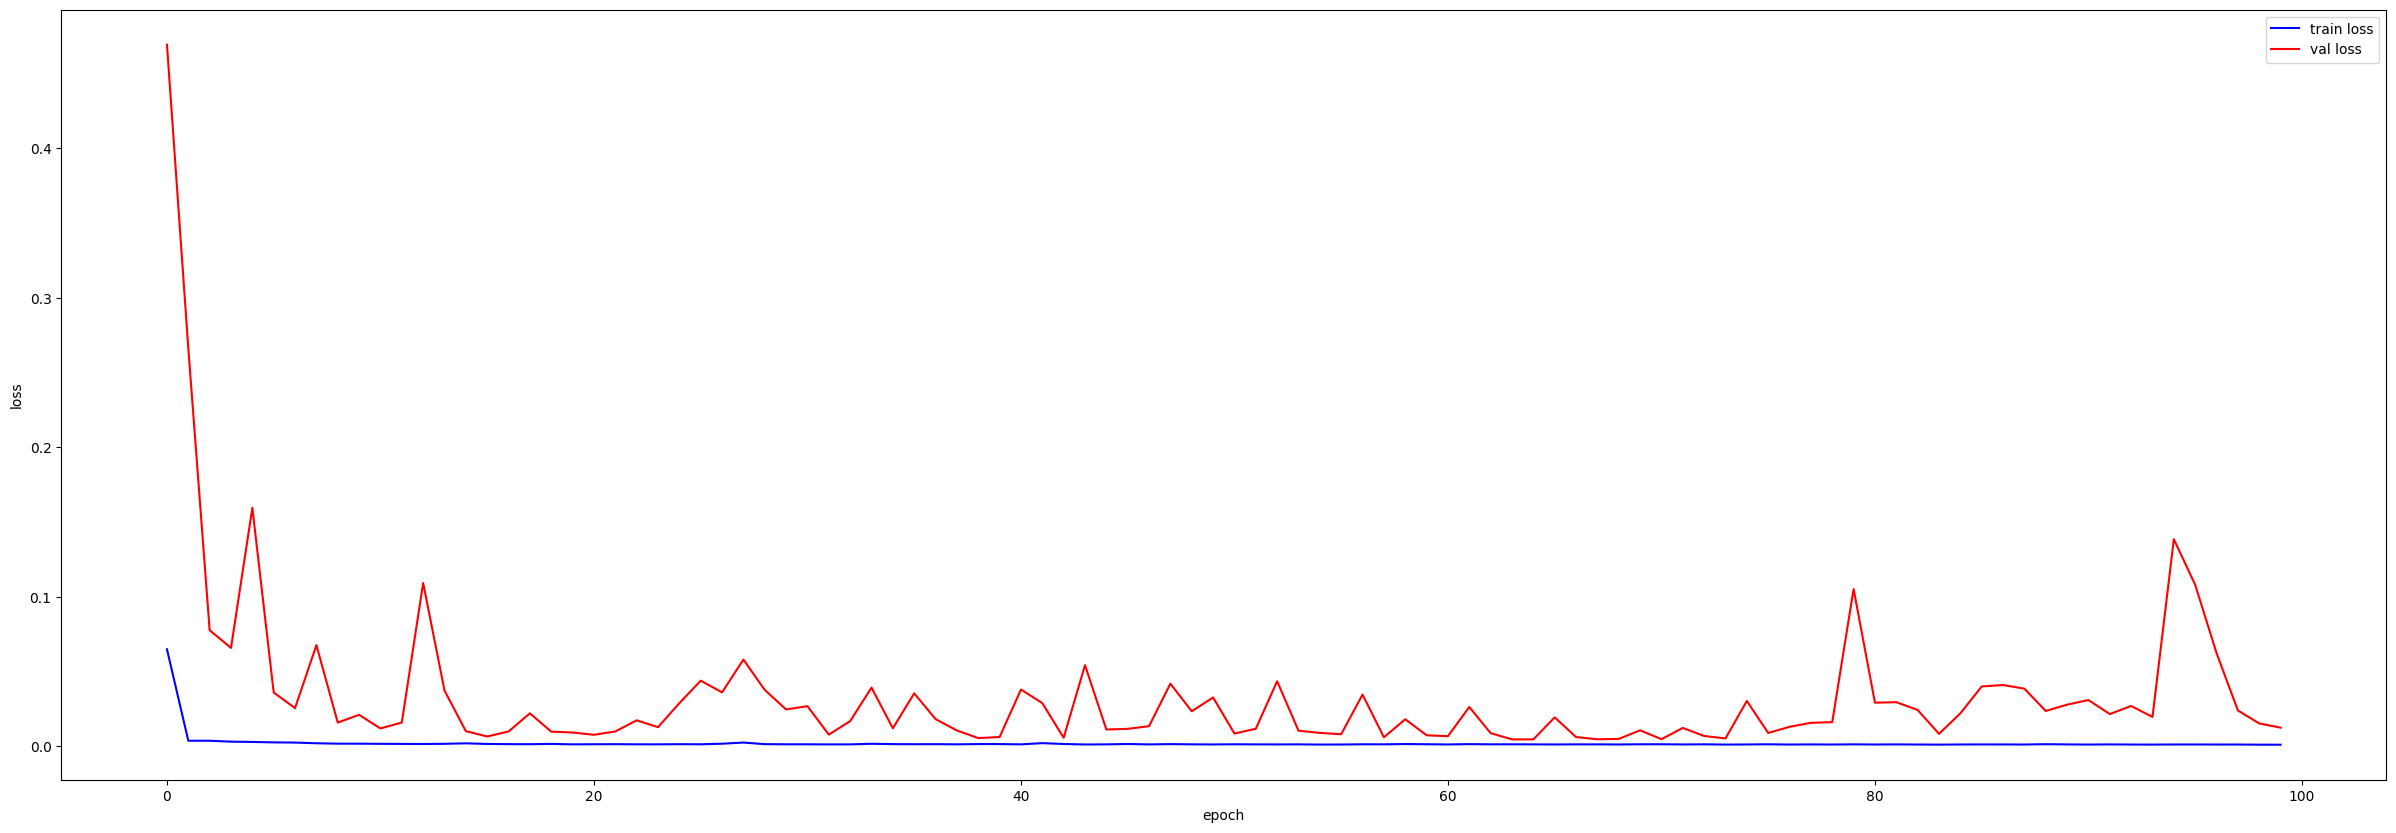

                           Close_lead1  Model forecast
Date                                                  
2022-05-02 00:00:00-04:00  4175.479980     4149.823730
2022-05-03 00:00:00-04:00  4300.169922     4183.064453
2022-05-04 00:00:00-04:00  4146.870117     4383.204102
2022-05-05 00:00:00-04:00  4123.339844     4055.475586
2022-05-06 00:00:00-04:00  3991.239990     3970.779541
...                                ...             ...
2024-05-03 00:00:00-04:00  5180.740234     5102.008789
2024-05-06 00:00:00-04:00  5187.700195     5005.691406
2024-05-07 00:00:00-04:00  5187.669922     4925.210449
2024-05-08 00:00:00-04:00  5214.080078     4988.111328
2024-05-09 00:00:00-04:00  5222.680176     5085.833984

[509 rows x 2 columns]
best_val_loss = 0.004685581625381019
MSE = 0.023378428840282454
MASE = 1.0107183731547151
RMSE = 95.58700724926958
SMAPE = 1.6914946385053975
MAE = 73.87744284519277
sharp_ratio = 0.0929483703072944
dropout_lstm: 0.0
weight_decay: 1e-05
learning_rate: 0.001
num

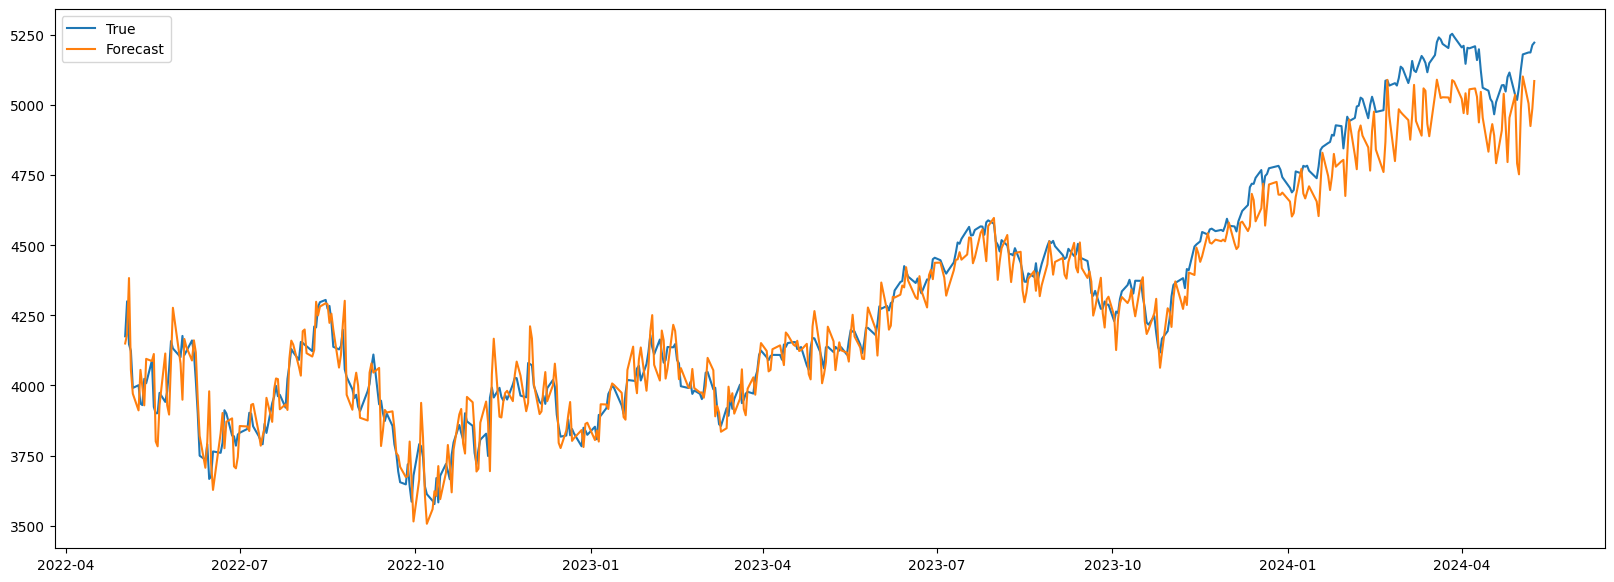

In [ ]:
param_grid = copy_from_best(best_params)
param_grid['lstm_layers'] = [1,2,3]
param_grid['dropout_lstm'] = [0.0, 0.2]
    # 'num_lstm_hiddensize': [num_lstm_hiddensize],
    # 'lstm_layers': [lstm_layers],
    # 'filters': [filters],
    # 'kernel_size': [kernel_size],
    # 'bidirectional': [bidirectional],
param_grid['filters'] = [32, 64, 128]
param_grid['kernel_size'] = [1, 3, 5]
param_combinations = list(product(*param_grid.values()))
best_params = grid_search(param_combinations)

param_grid = copy_from_best(best_params)
for key, value in param_grid.items():
    print(f"{key}: {value[0]}")